<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Data-Loading" data-toc-modified-id="Imports-and-Data-Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Data Loading</a></span></li><li><span><a href="#Data-Loading-and-EDA" data-toc-modified-id="Data-Loading-and-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Loading and EDA</a></span></li><li><span><a href="#Finding-Optimal-Architecture" data-toc-modified-id="Finding-Optimal-Architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finding Optimal Architecture</a></span></li><li><span><a href="#Fitting-models-Stage" data-toc-modified-id="Fitting-models-Stage-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting models Stage</a></span></li><li><span><a href="#Forecasting:-Visual-Analysis-and-R2-score" data-toc-modified-id="Forecasting:-Visual-Analysis-and-R2-score-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Forecasting: Visual Analysis and R2 score</a></span></li><li><span><a href="#Long-Term-forecasting-(full-cycle)" data-toc-modified-id="Long-Term-forecasting-(full-cycle)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Long-Term forecasting (full-cycle)</a></span></li><li><span><a href="#Collecting-all-metrics-and-Binnary-Classifiers" data-toc-modified-id="Collecting-all-metrics-and-Binnary-Classifiers-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Collecting all metrics and Binnary Classifiers</a></span></li><li><span><a href="#Testing-models-on-randomly-selected-companies-from-clusters" data-toc-modified-id="Testing-models-on-randomly-selected-companies-from-clusters-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Testing models on randomly selected companies from clusters</a></span></li></ul></div>

**Description**  
In this notebook RNN (LSTM) models will be created and fitted for sector composites and clusters centers. On last stage fitted models will be tested on randomly chosen companies from clusters

**Main Aspects**
- given the large number of models (26), the optimal parameters will be selected with the following limitations
  - I will use unique architecture for all models, which will be defined after tuning some of hyperparams for 2 time series
  - reccurent layer used for RNN - LSTM
  - Regularization - based on single Dropout Layer (after all LSTM-layers)
  - tuned hyperparams for architecture: number of nodes in LSTM layes (identical for each LSTM layer) and dropout ratio
  - model compile params: optimization - 'adam', loss-function - MSE

- some of params were internally tested, but testing process not showed in this version of code:
  - best window size = 90
  - optimal number of LSTM-layers = 1
    
- finally fitted models will be exported to h5 format and saved to `models` folder
  
- features data: {day_of_week, day_in_month, month} will be generated in input tensors
    - features nessecity will be tested on EDA stage
    
- in this BASIC VERSION of RNN I will not include financial statements as features


- Validation and Testing:
  - latest 20% of timeline reserved for TEST DATASET
  - validation timeline portion (in history) - 15%
  - final metrics - R2 score for one-step-forecasts and full-cycle-forecasts on test datasets.
  
  
- Data Unit
  - as for ARIMA models - I will use only Normalized Prices, which will be scaled with MinMaxScaler
  
**Functions**  
- `add_period_cols` - add to given df columns with month, day of week and day of month based on index dates


- `eda_plots` - show 4 plots:
  - daily time serie and rolling average monthly time serie
  - average daily prices in different months
  - average daily prices in different days of month
  - average daily prices in different days of week


- `split_to_train_test` - split dataframe to train and test subsets based on test portion with taking to account datetime sequence


- `scale_data` - takes scaler instance, train and test dataframes as inputs and return scaled train and test dataframes and fitted scaler instances for feature and for target


- `create_tensor` - based on given X, y and window lenth create np.arrays (3D-tensor for X adjusted to window length y)


- `build_rnn_multiple_lstm` - build and compile tensorflow.keras.Sequential instance based on given params which is ready to fit (see details on arguments in function annotation)


- `fit_run_plot` - run and create history object based on compiled rnn model, given X and y datasets and other params (see details in function annotation)


- `forecast_1step_rnn` - create 1-step-ahead forecast on given model and dataset, plot y_true and y_predicted in inverse_transformed units and return y_true and y_predict


- `forecast_Nsteps_rnn` - same function as `forecast_1step_rnn`, but creates full-cycle forecast version
  - this function works only for 90-days window_size!
  - here, final forecast generated as concatenated 1-step forecasts
  - each of 1-step forecast based on previouly predicted values as y_true


- `create_binnary_vector` - based on given array create binnary array, where 1 - means positive change (P(t) - P(t-1))


**Recommendation** 
- It is important to say, that some part of code can take a lot of time (hours).
- For such cells notices presented
- Also, in some part checkpoint presented
- If you need to run the code from the beginning, the following parts could be ignored:
  - Finding optimal RNN Architecture: 3.2, 3.3, 3.4, 3.5, 3.6 (in order to save visual results from previous runs, do not run any part of this code and do not Restart Kernel with CLEAR Output)
  - Main Fit stage: 4.2, 4.3, 4.4 (these cells can take up to 4 hours with CUDA and GPU)

#### Imports and Data Loading

In [190]:
# 1.0 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, pickle, os
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import warnings
import time
from datetime import date as dt
from sklearn.metrics import r2_score, f1_score, accuracy_score
import itertools
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [191]:
# 1.1 Configs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

%matplotlib inline
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [192]:
# 1.2. project_lib functions
from project_lib import add_period_cols, eda_plots, split_to_train_test
from project_lib import scale_data, create_tensor, build_rnn_multiple_lstm
from project_lib import fit_run_plot, forecast_1step_rnn, forecast_Nsteps_rnn
from project_lib import create_binnary_vector

In [193]:
# 1.3. Loading datasets    

# normed sector composite prices
with open('datasets_4_modelling/sector_composite_norm.pkl', 'rb') as f:
    sector_composite_norm = pickle.load(f)

# normed cluster center prices
with open('datasets_4_modelling/cluster_composite_norm.pkl', 'rb') as f:
    cluster_composite_norm = pickle.load(f)

# companies per sectors (NetMarginPrices) 
with open('datasets_4_modelling/cluster_test_comps.pkl', 'rb') as f:
    cluster_comps = pickle.load(f)

# companies per cluster (NetMarginPrices) 
with open('datasets_4_modelling/sector_test_comps.pkl', 'rb') as f:
    sector_comps = pickle.load(f)

#### Data Loading and EDA

Let's select 2 random time series: for composites and for cluster centers

In [194]:
# 2.1. Selecting random sector and cluster
sector_name = np.random.choice(sector_composite_norm.columns, np.random.seed(RANDOM_SEED))
print(f'for sectors {sector_name} randomly selected')
cluster_name = np.random.choice(cluster_composite_norm.columns, np.random.seed(RANDOM_SEED))
print(f'for cluster centers {cluster_name} randomly selected')

sector = pd.DataFrame(sector_composite_norm[sector_name])
cluster = pd.DataFrame(cluster_composite_norm[cluster_name])

for sectors Financial randomly selected
for cluster centers IXG randomly selected


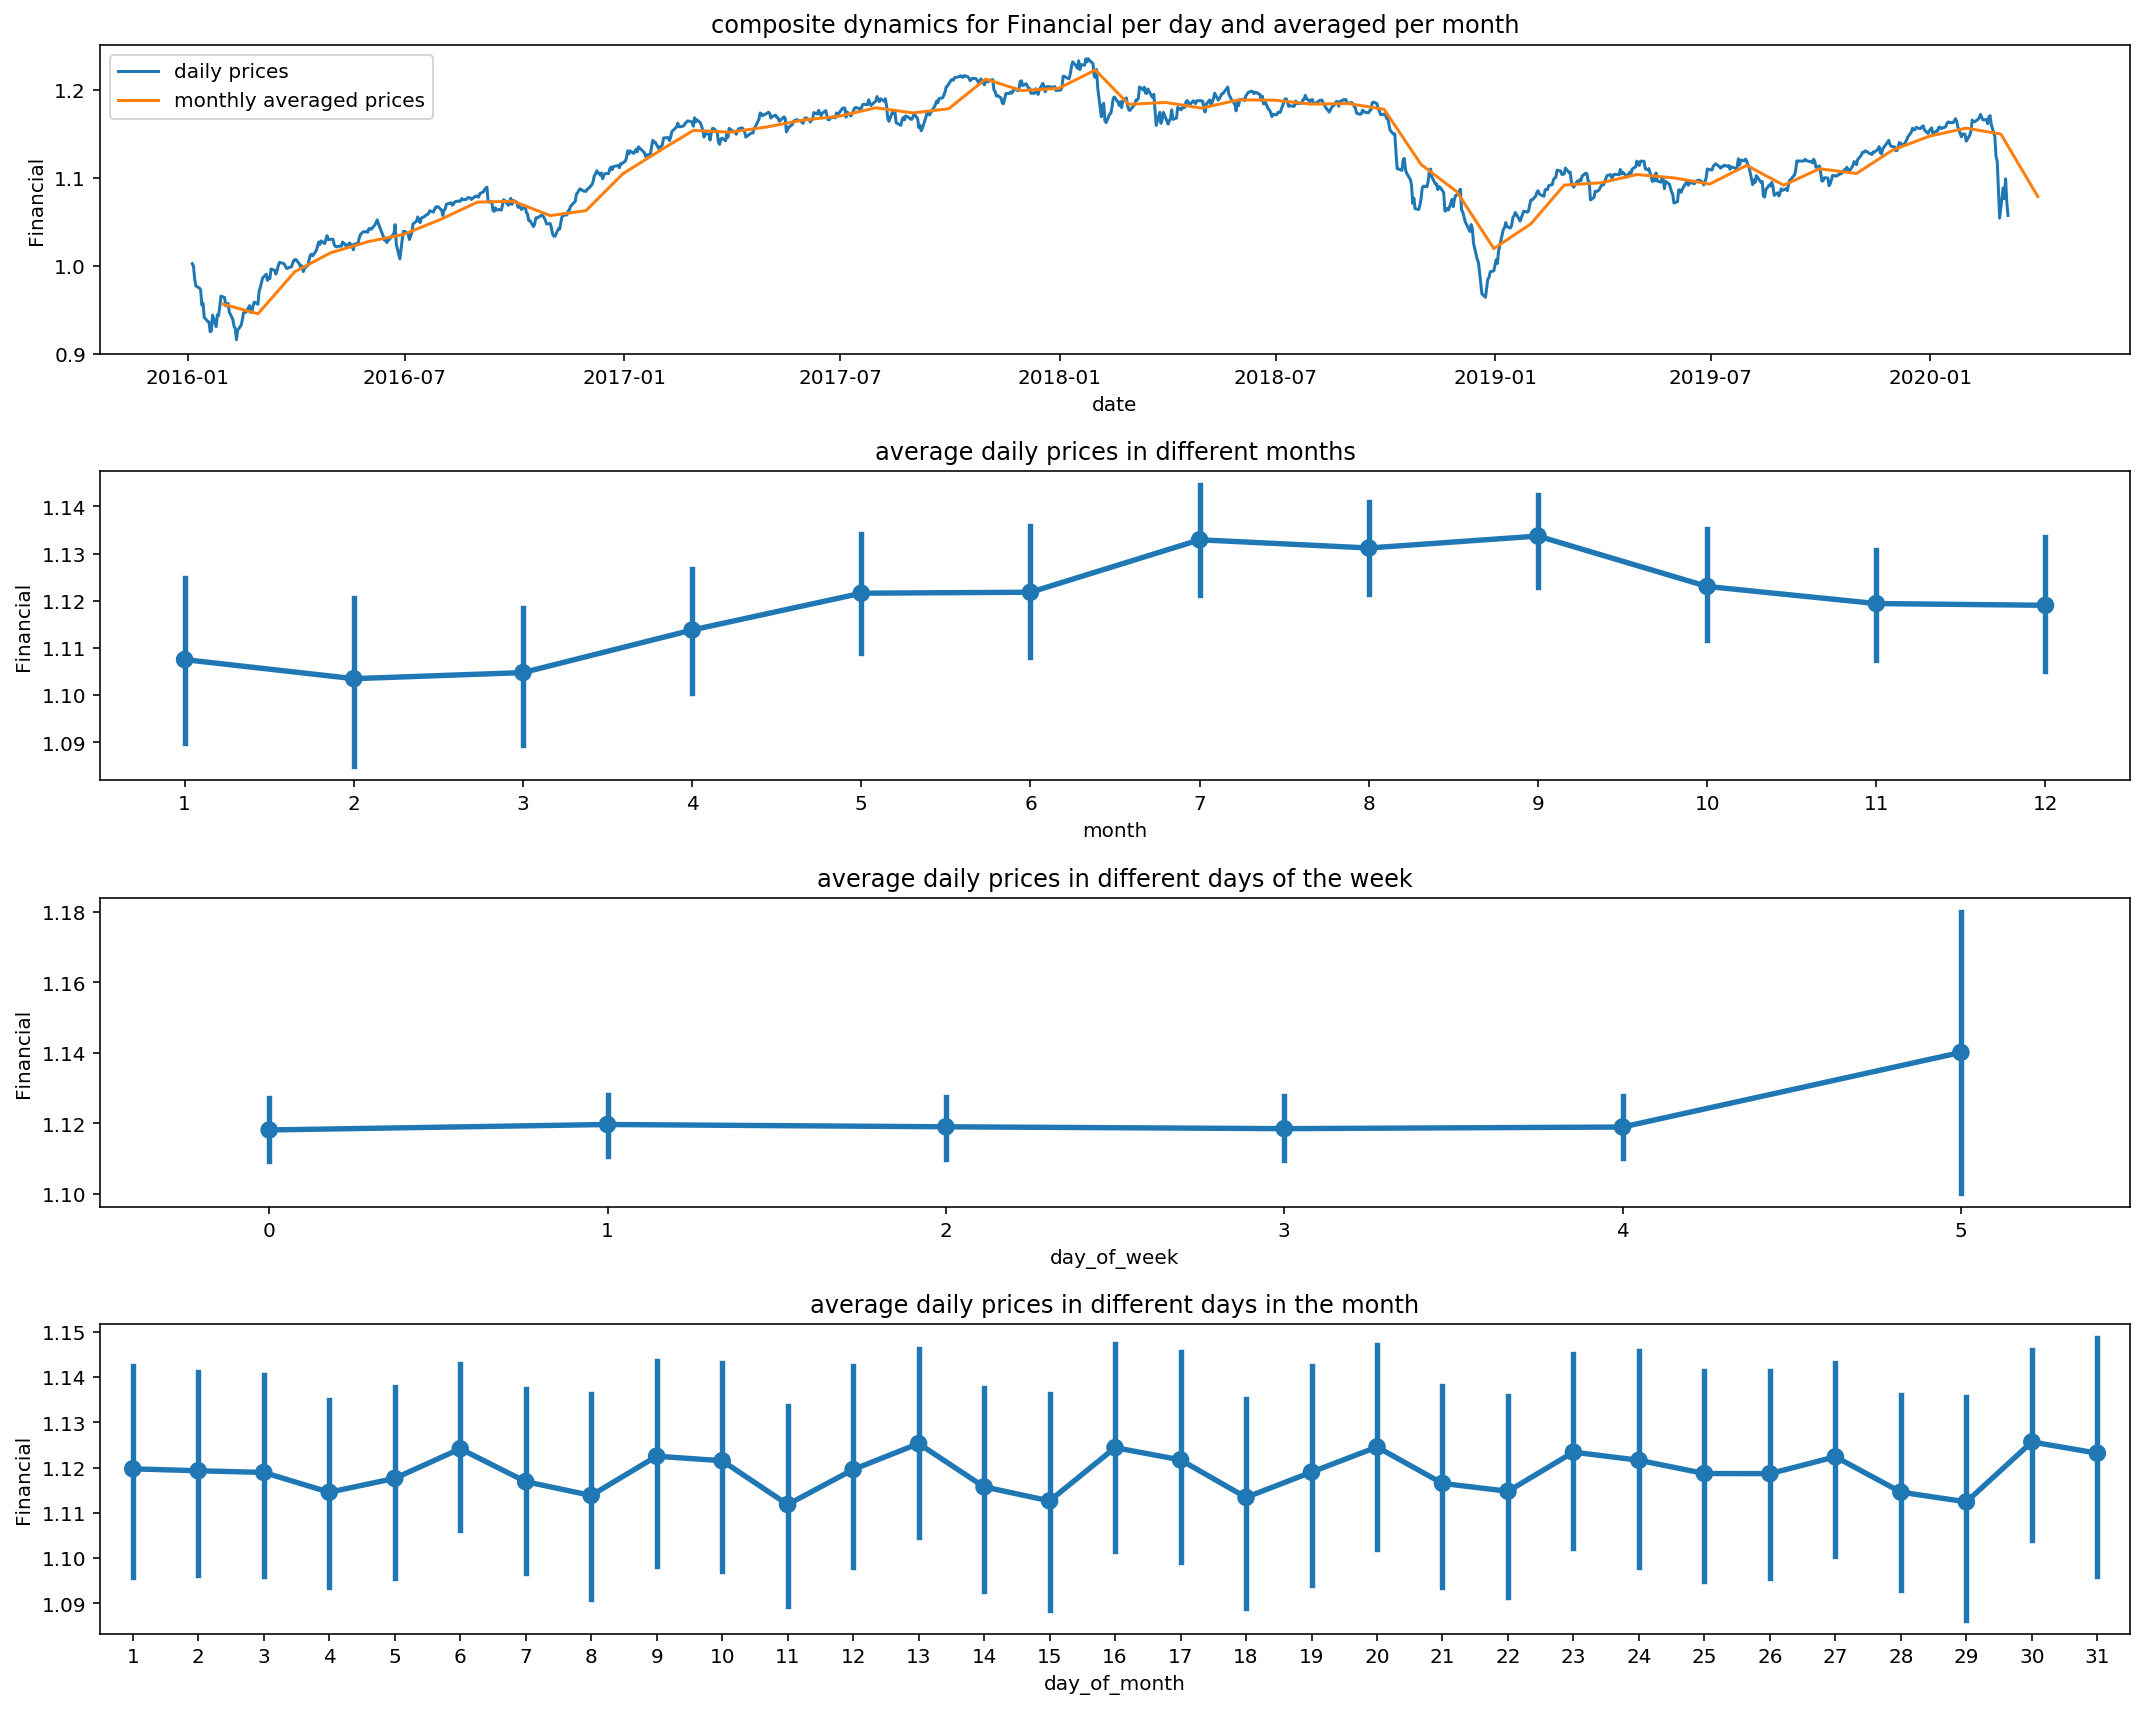

In [195]:
# 1.3. EDA on chosen sector

sector = add_period_cols(sector)
eda_plots(sector, sector_name)

EDA issues for sector composite (Finance):
- at the quotes averaged by months - it is difficult to judge about explicit cycles, but within a quarter they may be implicitly present (perhaps it is connected with quarterly reporting issues)
- there is some dependence of quotes on months, or rather seasons (chart 2)
- based on chart 3: on Saturdays the average price and volatility of quotes increases, on other days - it does not change, but this statement should also be checked by the cluster
- in graph 4 you can distinguish short cycles of 3-5 days long

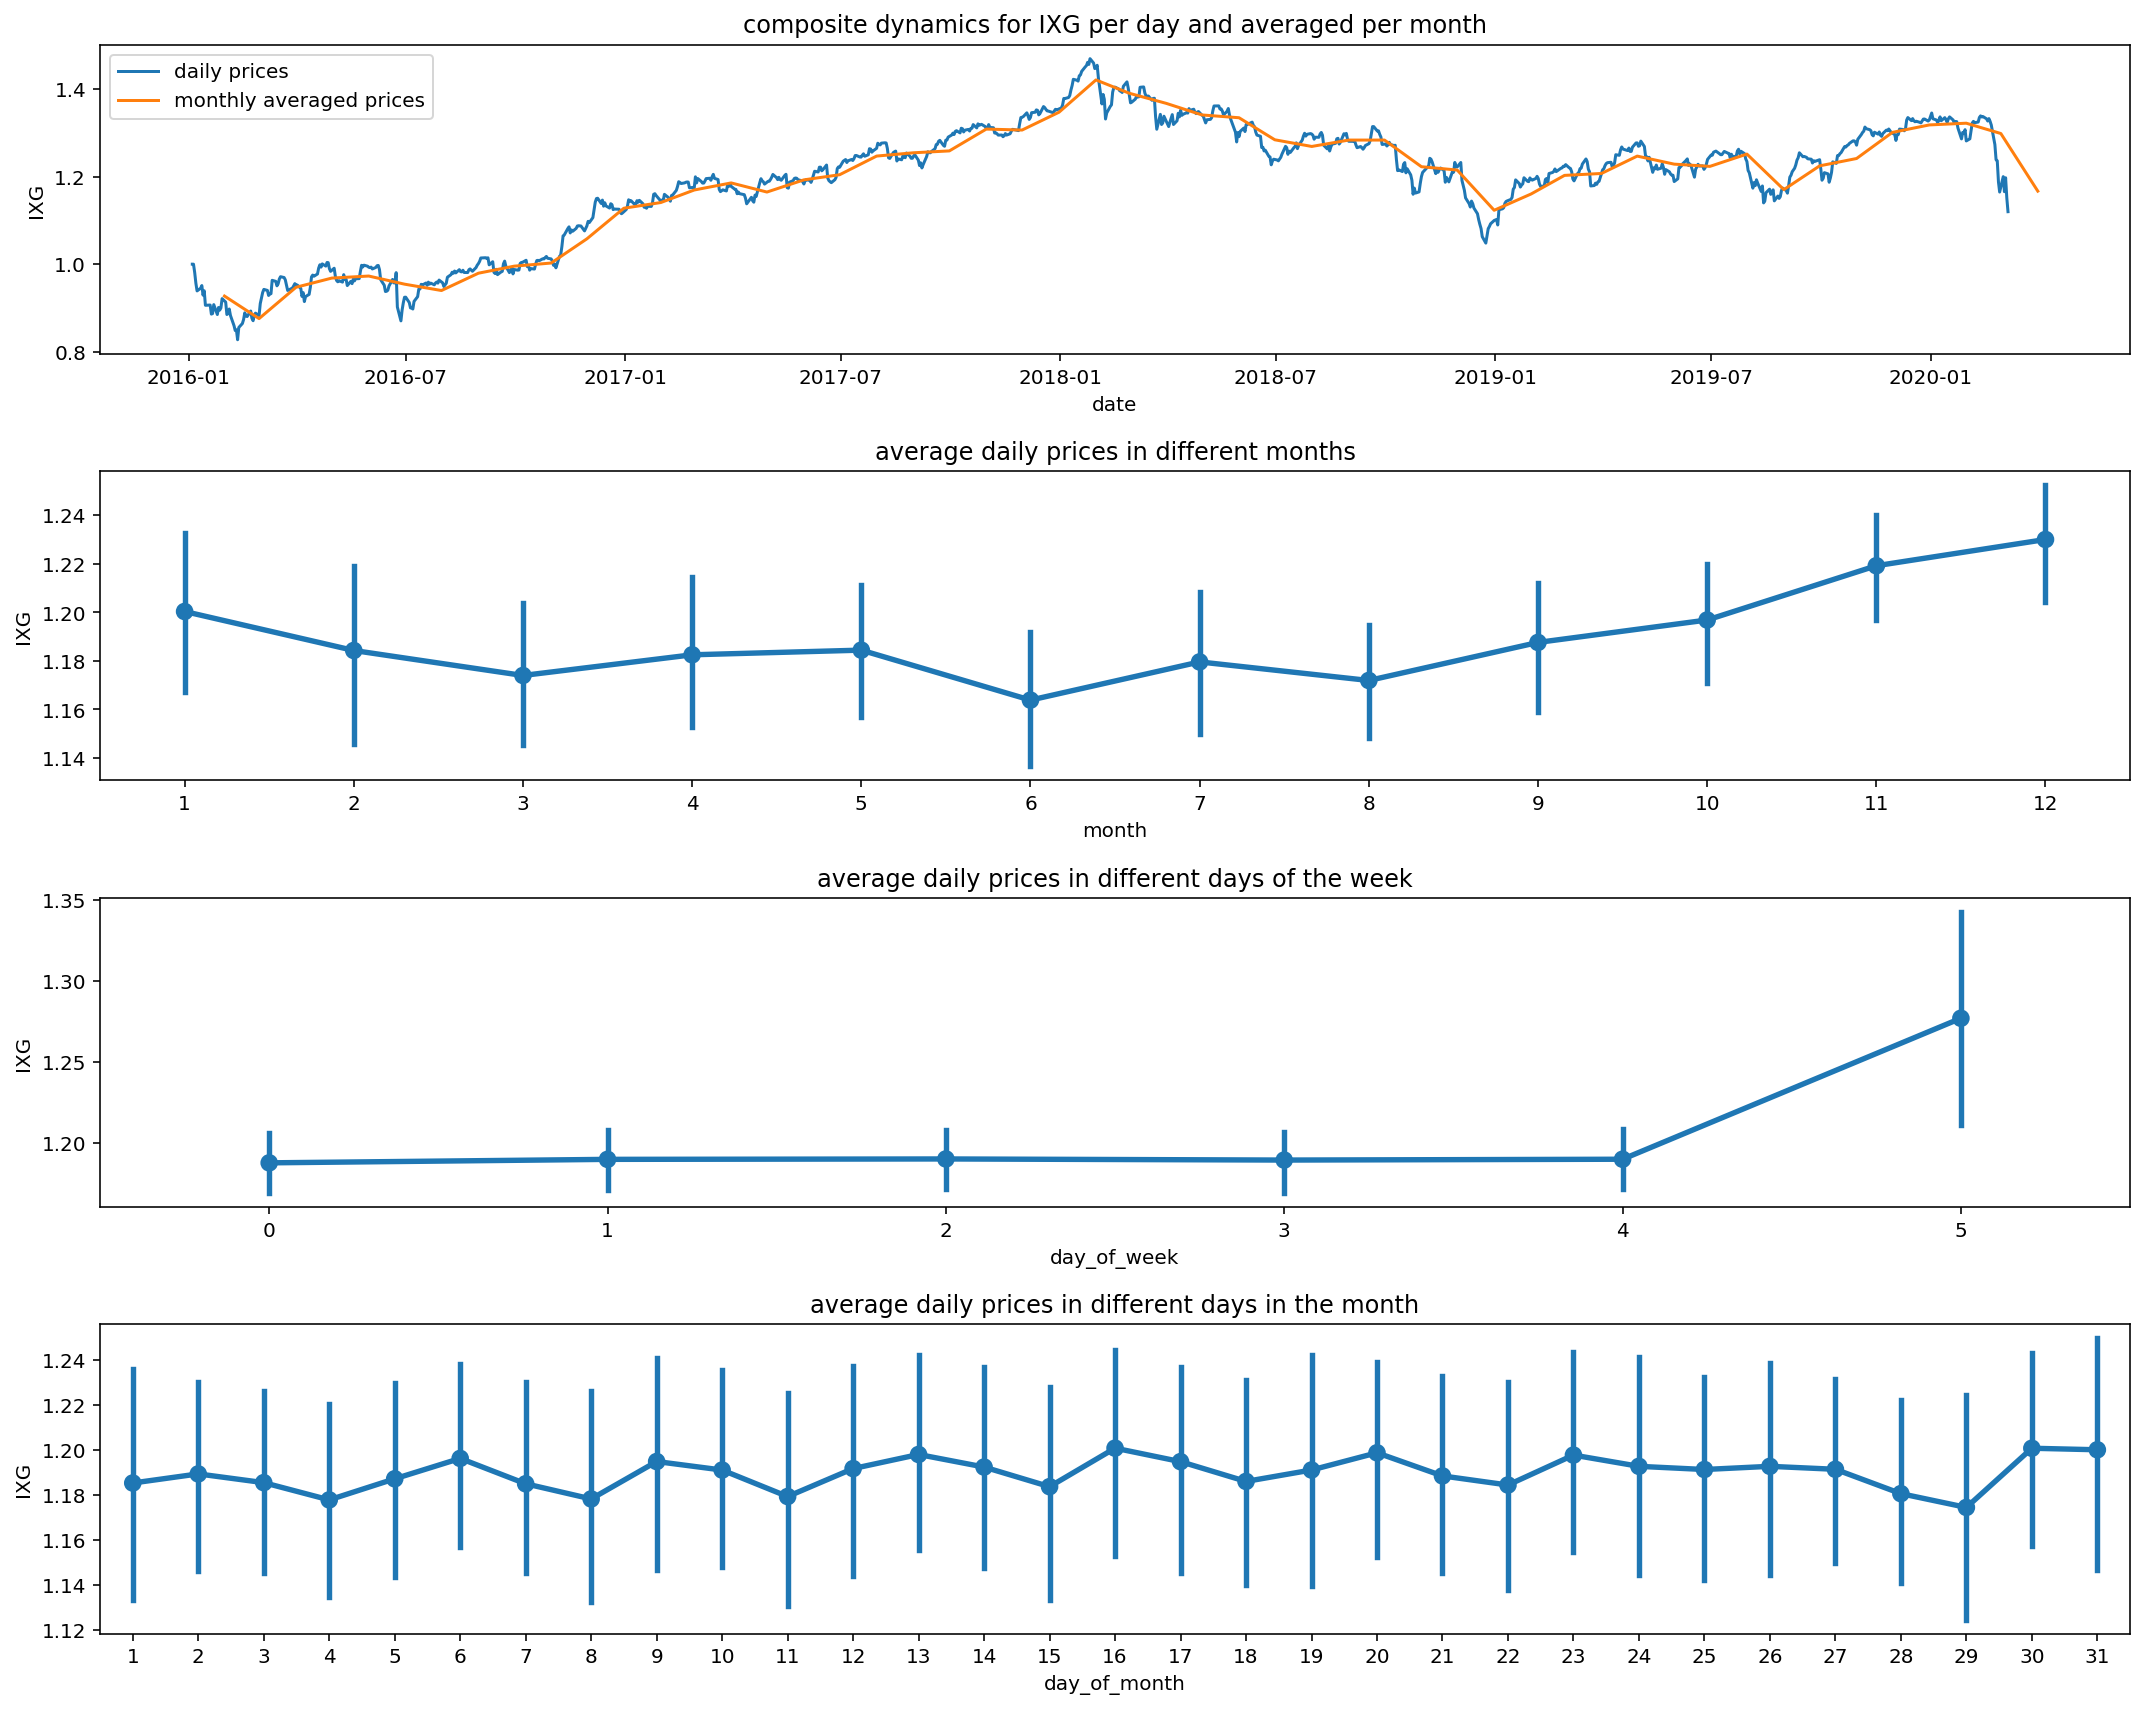

In [196]:
# 1.4. EDA on chosen cluster center

cluster = add_period_cols(cluster)
eda_plots(cluster, cluster_name)

In general, the conclusions of the IXG company's analysis are similar to the previous conclusions, so for RNN it is suggested to leave the generated cycle variables except for day_of_week and go to the selection of the optimal model architecture.  
Removal of day_of_week is due to the fact that the total number of Saturdays in which the trades took place is only 2 out of 1082 days.

#### Finding Optimal Architecture

In this part an attempt will be made to select the optimal model architecture for further training of all models. In doing so, the selection of parameters will be carried out taking into account the following aspects:

- I will use ReLU activation function for all cases (it was tested internally)


- In order to save time, I will run param search only for 2 time series defined earlier:
  - Financials from sectors
  - IXG from cluster centers


- Param search covers dropout rate and number of nodes in LSTM
  - Dropout rate: 0.10, 0.15 and 0.25
  - Number of nodes in LSTM layers (per layer): 32, 96 and 128


- Additional full-dense layer will be tested on chosen architecture


- Multiple LSTM-layers (2 and 3) were tested internally and showed strong overfitting


- Basic fixed params in param search
  - window size = 90 (other window sizes tested internally)
  - number of epochs = 150
  - bunch_size = 16
  - activated Early Stopping mechanizm with val_loss and length of next period = 0.2 of all epochs 
  

- Key factor for choosing optimal:
  - Minimal loss function value
  - Number of epochs to obtain optimum
  - Visual shape of learning curves


- Other aspects:
  - all these operations take a 2-2.5 hours with activated CUDA support and GPU 1080Ti
  - In order of safety final chosen architecture is in 3.7 and could be used without running 3.2-3.6

In [197]:
# 3.1. Preparing datasets for calculation

# 3.1.1. Dropping day_of_week
try:
    sector = sector.drop(columns=['day_of_week'], axis=1)
    cluster = cluster.drop(columns=['day_of_week'], axis=1)
except Exception:
    print('dropping operation already done')
    
print(f'number of features including composite itself: {sector.shape[1]}')

# 3.1.2. Split data to train and test
sector_train, sector_test = split_to_train_test(sector, test_portion=0.2)
cluster_train, cluster_test = split_to_train_test(cluster, test_portion=0.2)
print(f'shape for train: {sector_train.shape}, for test: {sector_test.shape}')

# 3.1.3. Scaling datasets
print(f'stats for {sector_name}')
print(f'-'*60)
sector_train_scaled, sector_test_scaled, sector_scaler, sector_target_scaler = scale_data(MinMaxScaler(), sector_train,
                                                                                          sector_test, 
                                                                                          target_name=sector_name,
                                                                                          show_stats=True)

print(f'stats for {cluster_name}')
print(f'-'*60)
cluster_train_scaled, cluster_test_scaled, cluster_scaler, cluster_target_scaler = scale_data(MinMaxScaler(), 
                                                                                              cluster_train,
                                                                                              cluster_test, 
                                                                                              target_name=cluster_name,
                                                                                              show_stats=True)

# 3.1.4. Creating input tensors with window size = 90

sector_train_tensor, sector_train_target = create_tensor(sector_train_scaled, sector_train_scaled[sector_name],
                                                         window_size=90, show_shape=True)

cluster_train_tensor, cluster_train_target = create_tensor(cluster_train_scaled, cluster_train_scaled[cluster_name],
                                                         window_size=90, show_shape=True)


number of features including composite itself: 3
shape for train: (866, 3), for test: (216, 3)
stats for Financial
------------------------------------------------------------
train dataset statistics


Financial       month  day_of_month
count  866.000000  866.000000    866.000000
mean     0.634328    0.464938      0.487798
std      0.231706    0.315368      0.292297
min      0.000000    0.000000      0.000000
25%      0.460981    0.181818      0.233333
50%      0.707919    0.454545      0.466667
75%      0.831579    0.727273      0.733333
max      1.000000    1.000000      1.000000

test dataset statistics


Financial       month  day_of_month
count  216.000000  216.000000    216.000000
mean     0.635718    0.554293      0.496914
std      0.085098    0.321499      0.294832
min      0.432543    0.000000      0.000000
25%      0.565337    0.363636      0.233333
50%      0.621186    0.636364      0.500000
75%      0.703406    0.818182      0.766667
max      0.801637    1.000000      1.000000

stats for IXG
------------------------------------------------------------
train dataset statistics


IXG       month  day_of_month
count  867.000000  867.000000    867.000000
mean     0.538275    0.464402      0.487351
std      0.228229    0.315581      0.292425
min      0.000000    0.000000      0.000000
25%      0.292081    0.181818      0.233333
50%      0.576935    0.454545      0.466667
75%      0.706414    0.727273      0.733333
max      1.000000    1.000000      1.000000

test dataset statistics


IXG       month  day_of_month
count  216.000000  216.000000    216.000000
mean     0.666980    0.554293      0.496914
std      0.086302    0.321499      0.294832
min      0.455586    0.000000      0.000000
25%      0.606444    0.363636      0.233333
50%      0.659289    0.636364      0.500000
75%      0.744279    0.818182      0.766667
max      0.806685    1.000000      1.000000

shape of input tensor: (776, 90, 3)
shape of input tensor: (777, 90, 3)


Timeline for cluster centers is bigger than sector composites to 1 day due to initial data preparation on previous steps, but this difference is not material for further steps.

It can be noticed, that max - min differences for test data are almost twice lower than for train data, which can be explained with lower volatility for test data.

calculations for 32 nodes - 0.1 dropout_rate - 1 LSTM layers started..
Epoch 00075: early stopping
total time for learning: 161.81052112579346 sec


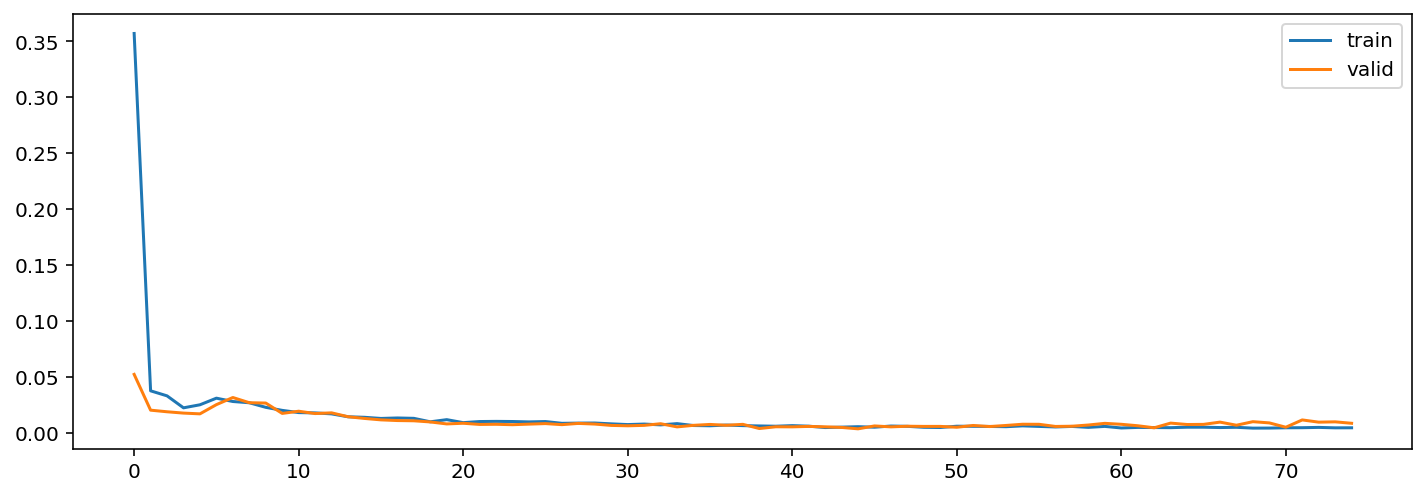

best epoch for valid set 44
best loss for valid set 0.003572228483051762
------------------------------------------------------------------------------------------
calculations for 32 nodes - 0.15 dropout_rate - 1 LSTM layers started..
Epoch 00051: early stopping
total time for learning: 108.78807139396667 sec


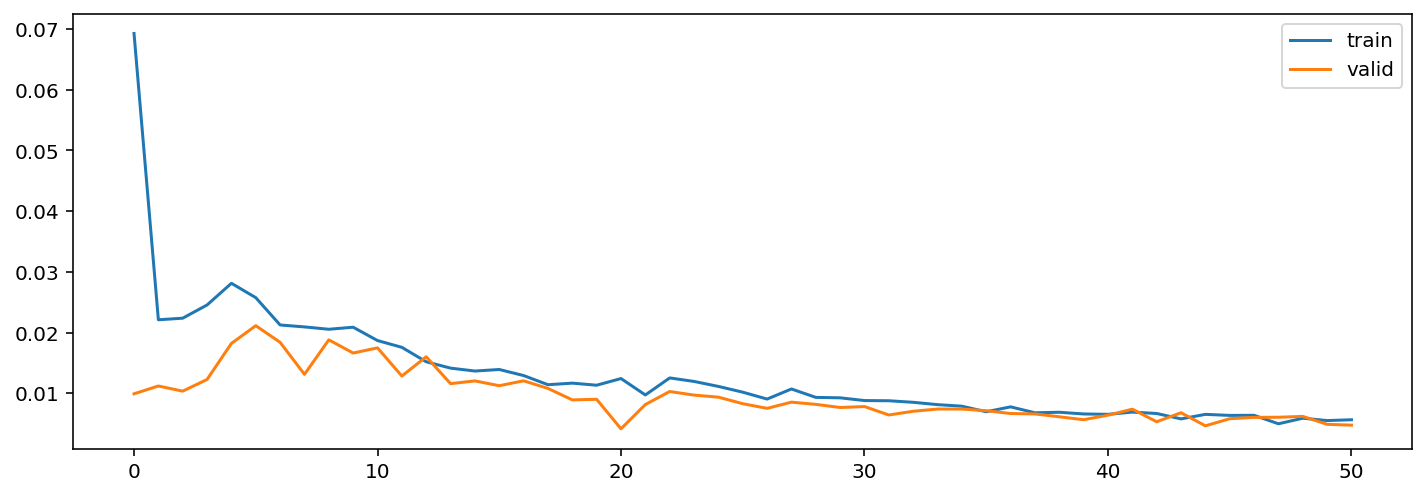

best epoch for valid set 20
best loss for valid set 0.004145078790875582
------------------------------------------------------------------------------------------
calculations for 32 nodes - 0.25 dropout_rate - 1 LSTM layers started..
Epoch 00038: early stopping
total time for learning: 81.76710510253906 sec


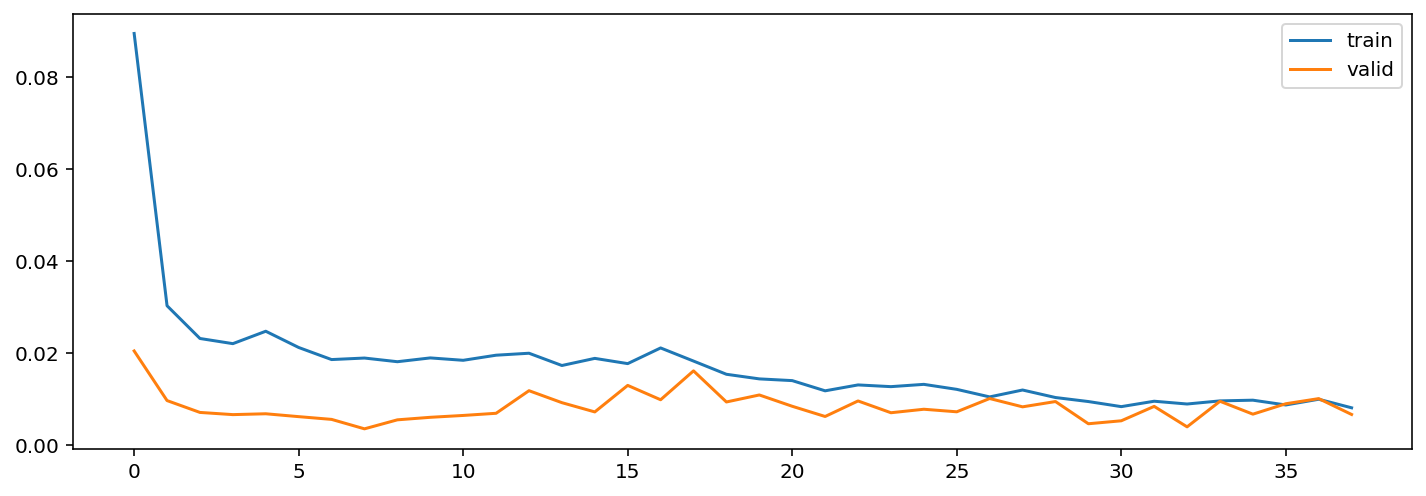

best epoch for valid set 7
best loss for valid set 0.00345425284268637
------------------------------------------------------------------------------------------
calculations for 96 nodes - 0.1 dropout_rate - 1 LSTM layers started..
Epoch 00096: early stopping
total time for learning: 204.4246985912323 sec


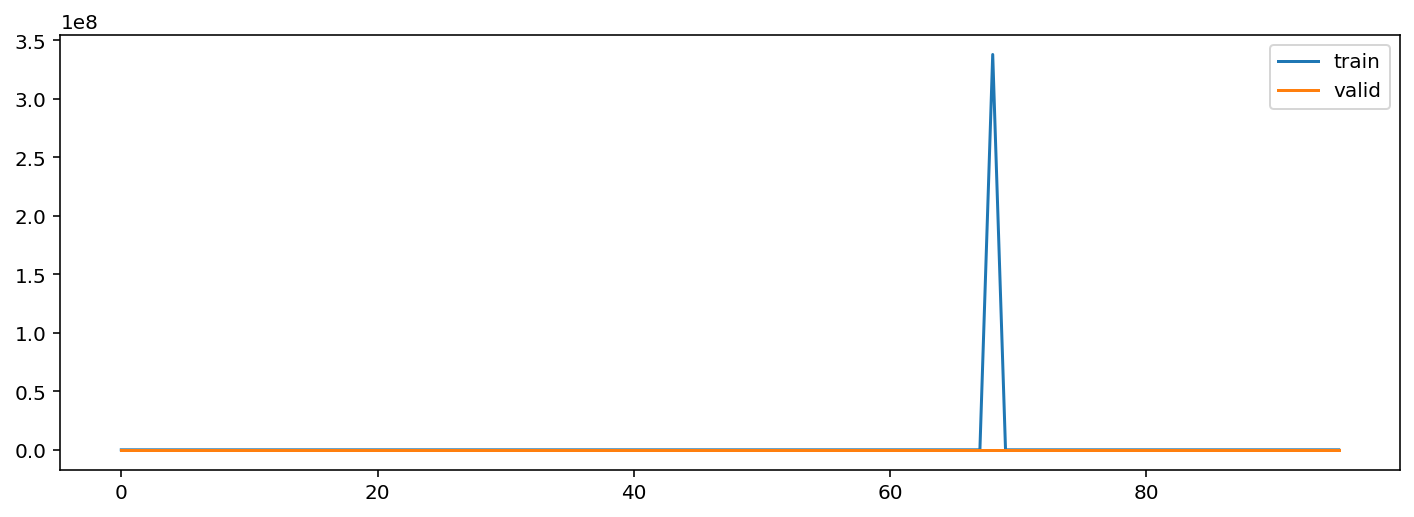

best epoch for valid set 65
best loss for valid set 0.004853123663646034
------------------------------------------------------------------------------------------
calculations for 96 nodes - 0.15 dropout_rate - 1 LSTM layers started..
Epoch 00088: early stopping
total time for learning: 190.7471797466278 sec


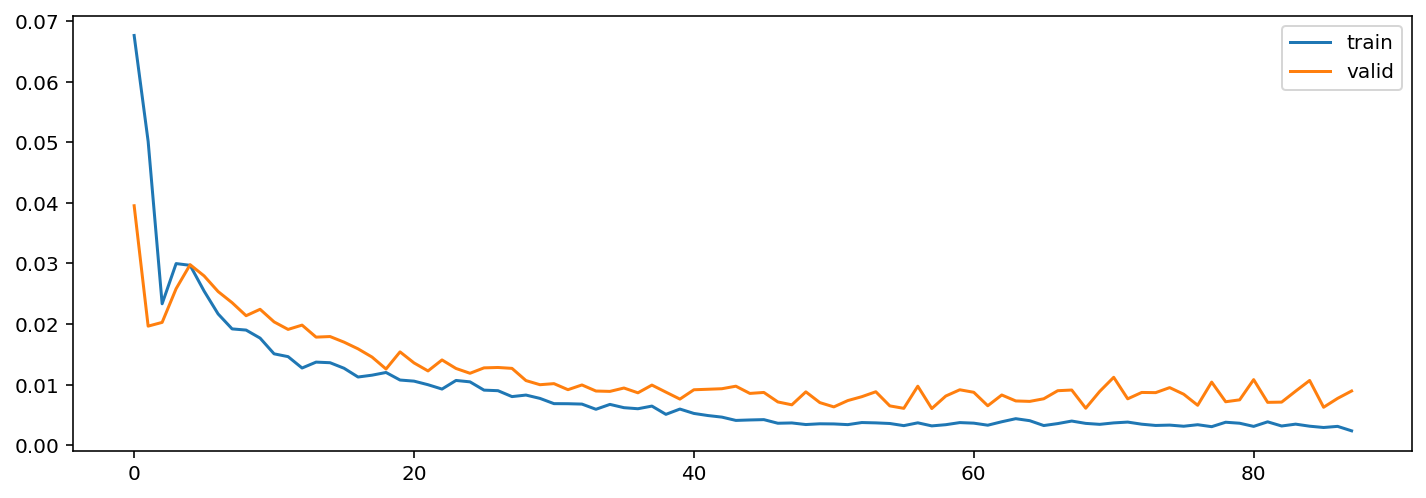

best epoch for valid set 57
best loss for valid set 0.006032026870351316
------------------------------------------------------------------------------------------
calculations for 96 nodes - 0.25 dropout_rate - 1 LSTM layers started..
Epoch 00094: early stopping
total time for learning: 202.72139358520508 sec


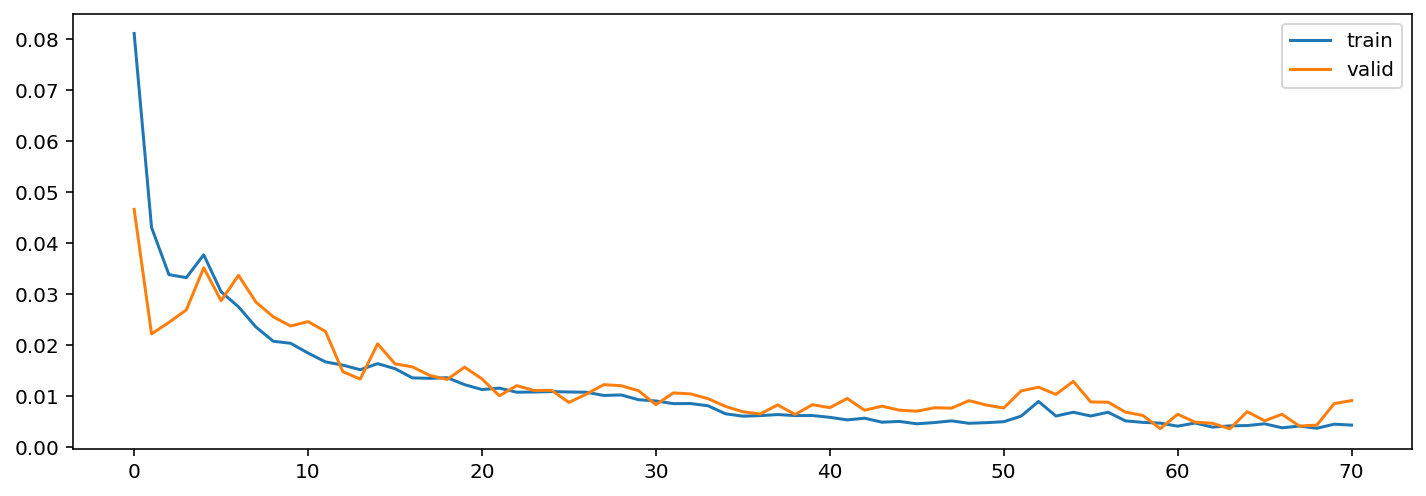

best epoch for valid set 71
best loss for valid set nan
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.1 dropout_rate - 1 LSTM layers started..
Epoch 00072: early stopping
total time for learning: 154.44691109657288 sec


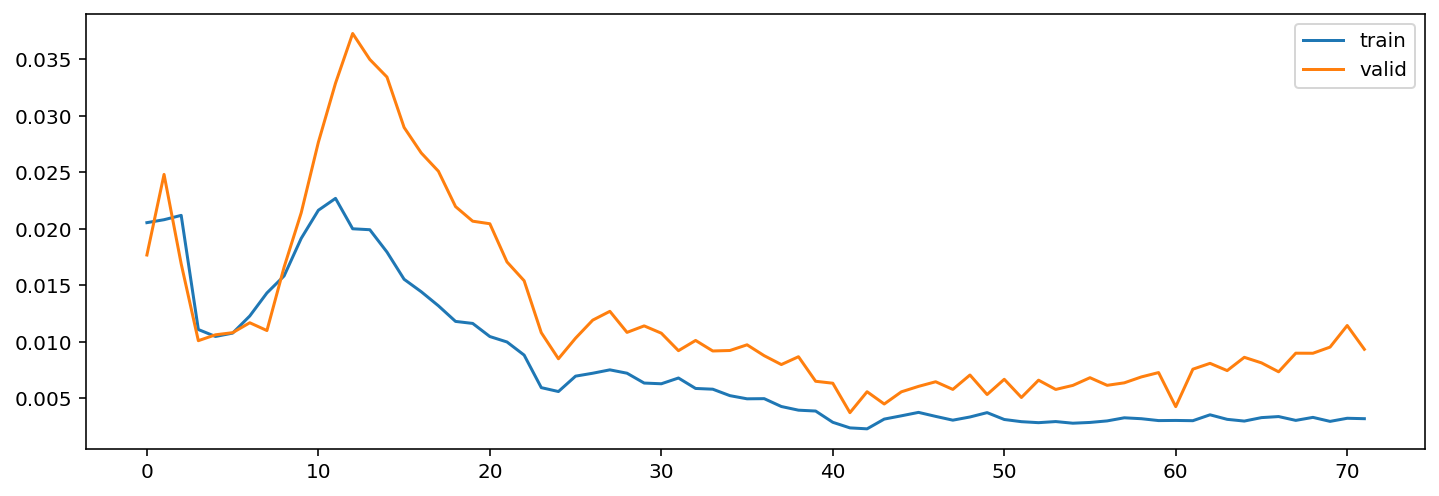

best epoch for valid set 41
best loss for valid set 0.003728935514919014
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.15 dropout_rate - 1 LSTM layers started..
Epoch 00095: early stopping
total time for learning: 206.52025938034058 sec


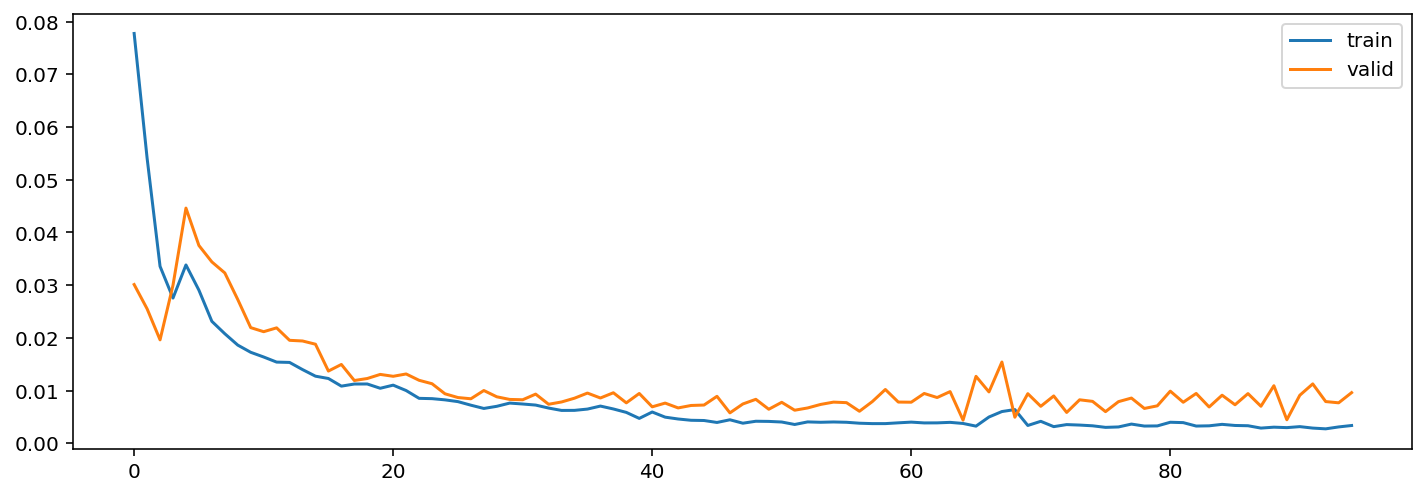

best epoch for valid set 64
best loss for valid set 0.00439333018168218
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.25 dropout_rate - 1 LSTM layers started..
Epoch 00070: early stopping
total time for learning: 152.5017614364624 sec


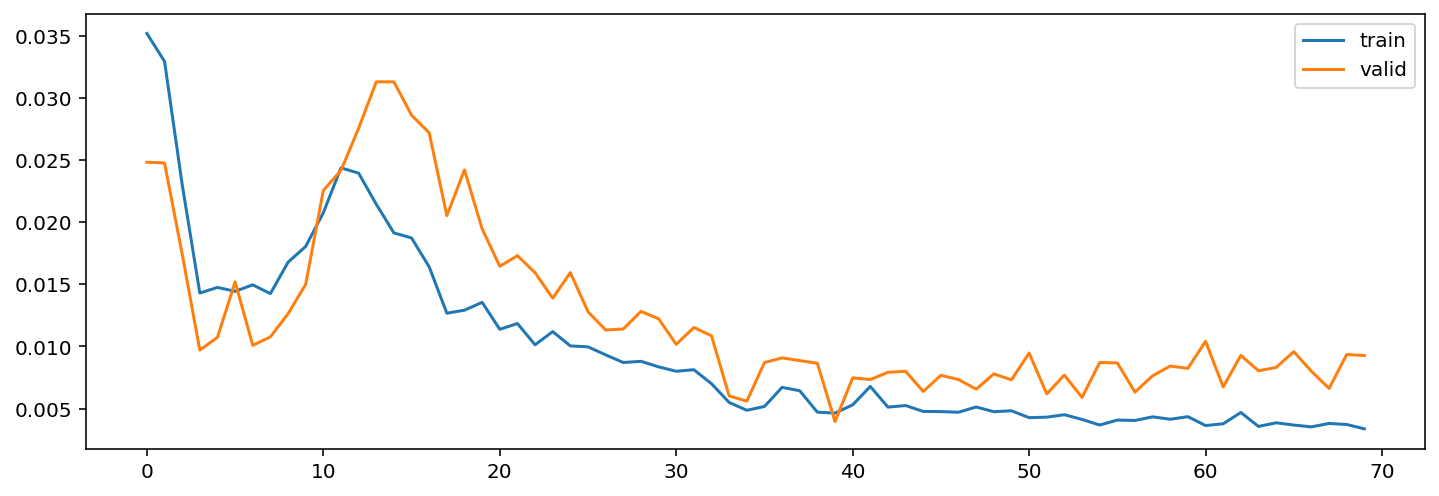

best epoch for valid set 39
best loss for valid set 0.003961400509987058
------------------------------------------------------------------------------------------


In [10]:
# 3.2. Calculating models for Sector
# attention: this cell can take up to 40 minutes with activated CUDA and GPU (1080Ti)
# I've put here optimized hyper-parameters space after some internal research
# NOTICE: it is recommended to ignore this part

lstm_n = [32, 96, 128]
dropout_rates = [0.1, 0.15, 0.25]
n_lstm = [0]
combs = list(itertools.product(lstm_n, dropout_rates, n_lstm))

titles = [str(i[0])+' nodes - '+str(i[1])+' dropout_rate - '+str(i[2]+1)+' LSTM layers' for i in combs]

param_grid = {t:dict(matrix_shape=sector_train_tensor.shape[1:],
                    lstm_units=c[0],
                    dropout_rate=c[1],
                    n_internal_lstm=c[2]) 
              for t,c in zip(titles, combs)}

sector_valid_losses, sector_valid_epochs = [], []

for title, params in param_grid.items():
    print(f'calculations for {title} started..')
    model = build_rnn_multiple_lstm(**params)
    history = fit_run_plot(model, sector_train_tensor, sector_train_target, n_epochs=150, batch_size=16, 
                           validation_split=0.15, verbose_mode=0, show_chart=True, display_total_time=True, 
                           display_model_summary=False, return_history=True, figsize=(12, 4), use_early_stopping=True)

    v_loss = np.array(history.history['val_loss'])
    
    sector_valid_losses.append(v_loss.min())
    sector_valid_epochs.append(v_loss.argmin())
    
    print(f"best epoch for valid set {v_loss.argmin()}")
    print(f"best loss for valid set {v_loss.min()}")
    print(f'-'*90)

calculations for 32 nodes - 0.1 dropout_rate - 1 LSTM layers started..
total time for learning: 321.4134199619293 sec


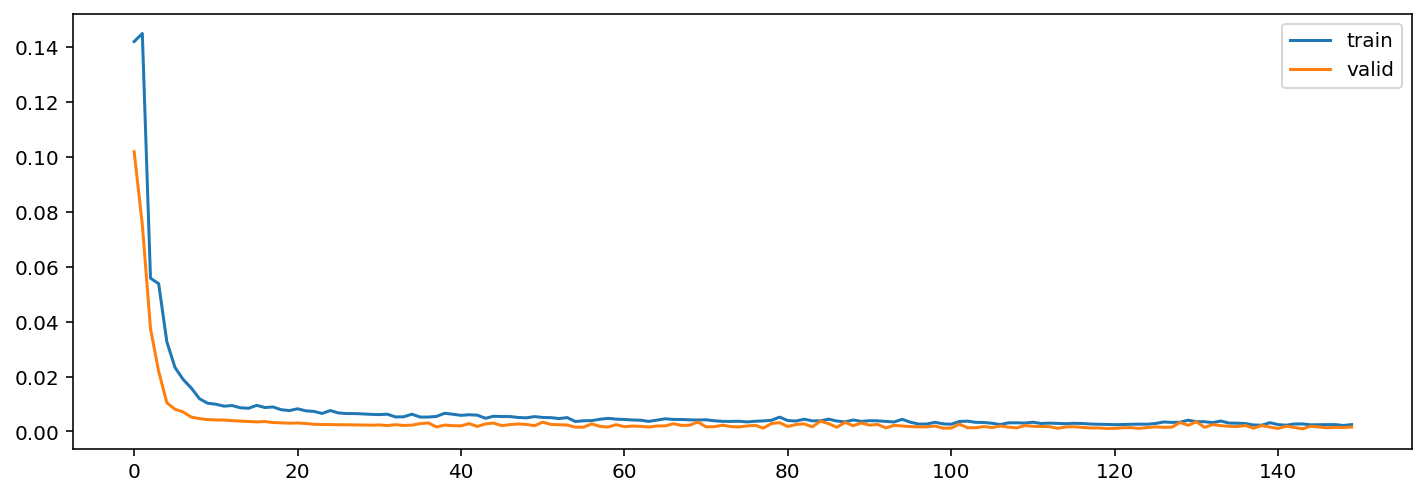

best epoch for valid set 143
best loss for valid set 0.0009530783540362285
------------------------------------------------------------------------------------------
calculations for 32 nodes - 0.15 dropout_rate - 1 LSTM layers started..
Epoch 00044: early stopping
total time for learning: 96.4823682308197 sec


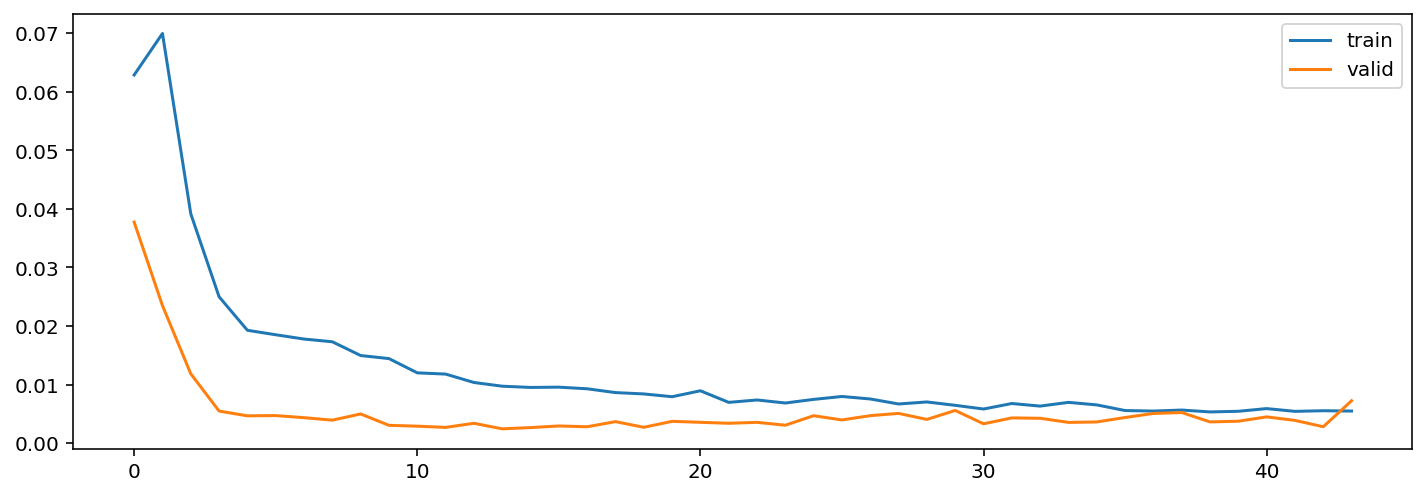

best epoch for valid set 13
best loss for valid set 0.0024391818452331945
------------------------------------------------------------------------------------------
calculations for 32 nodes - 0.25 dropout_rate - 1 LSTM layers started..
Epoch 00050: early stopping
total time for learning: 113.31450533866882 sec


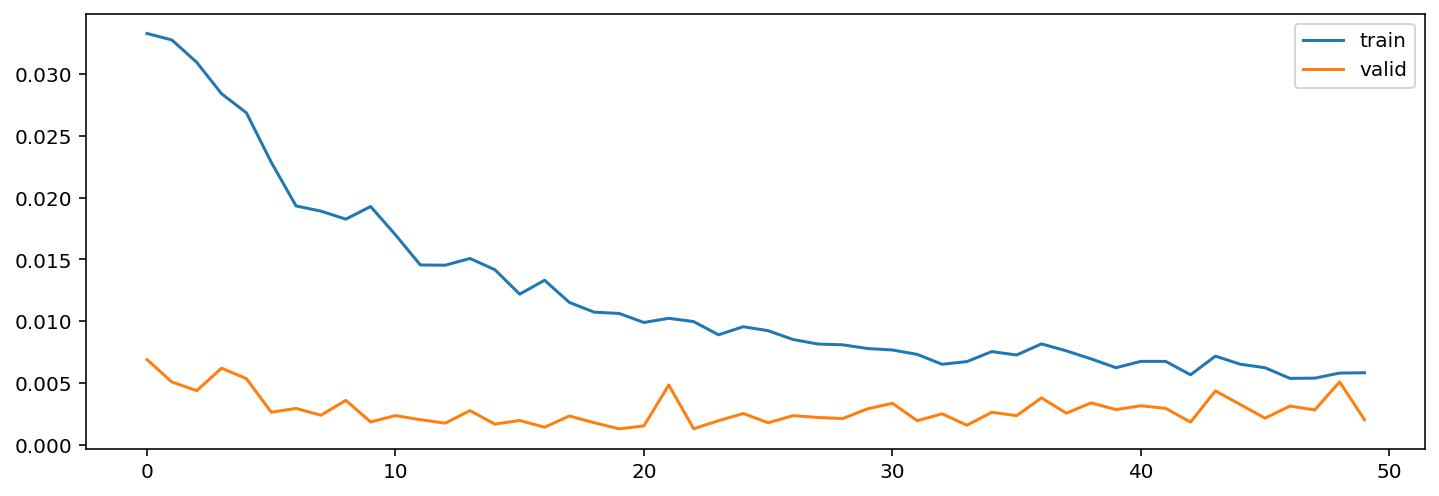

best epoch for valid set 19
best loss for valid set 0.0013047972921397474
------------------------------------------------------------------------------------------
calculations for 96 nodes - 0.1 dropout_rate - 1 LSTM layers started..
total time for learning: 335.2707164287567 sec


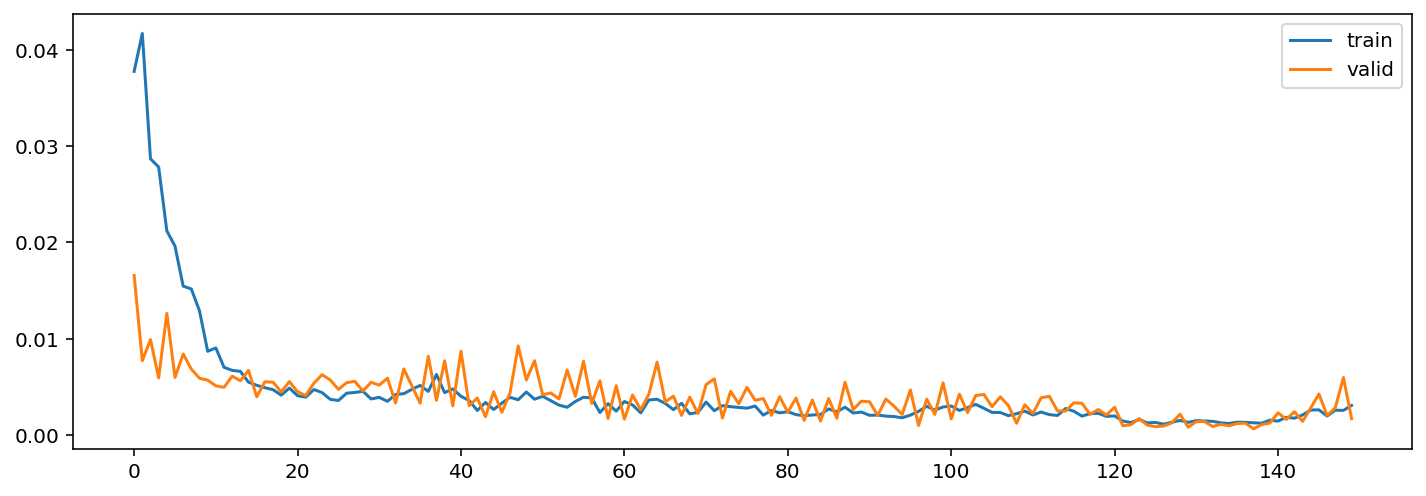

best epoch for valid set 137
best loss for valid set 0.0006394831540309784
------------------------------------------------------------------------------------------
calculations for 96 nodes - 0.15 dropout_rate - 1 LSTM layers started..
Epoch 00038: early stopping
total time for learning: 86.54529643058777 sec


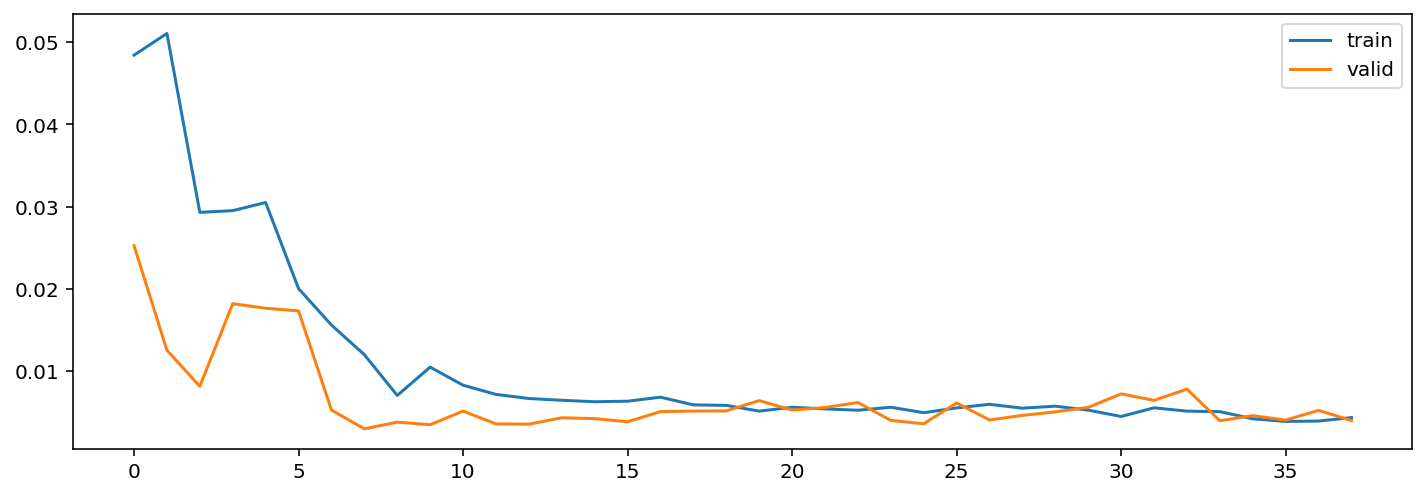

best epoch for valid set 7
best loss for valid set 0.002962456045485237
------------------------------------------------------------------------------------------
calculations for 96 nodes - 0.25 dropout_rate - 1 LSTM layers started..
total time for learning: 350.85350584983826 sec


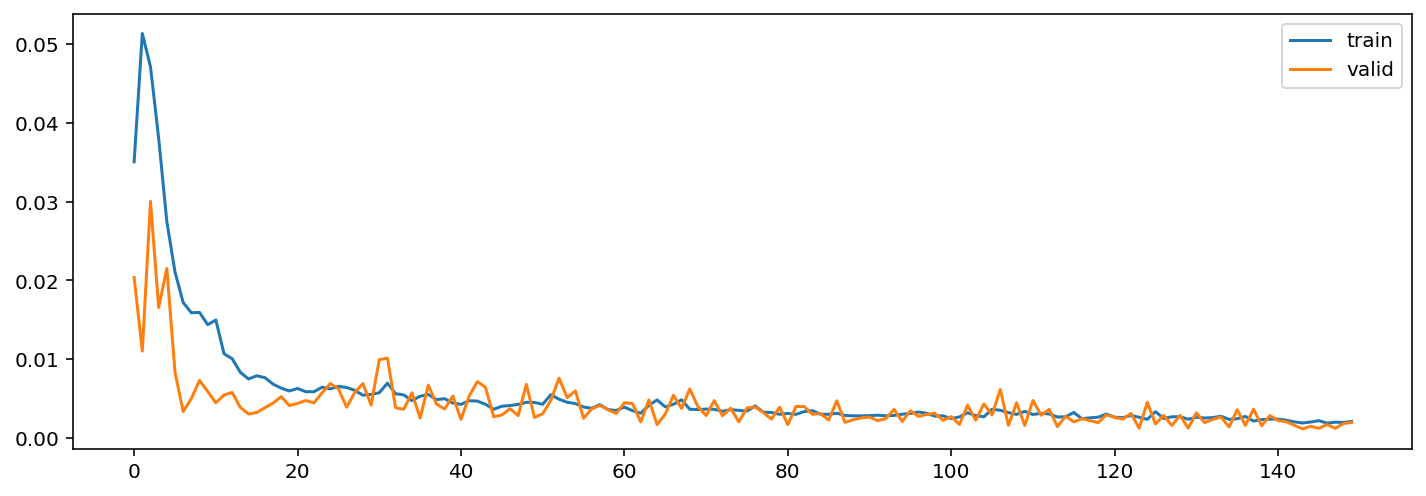

best epoch for valid set 143
best loss for valid set 0.0011505850771855977
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.1 dropout_rate - 1 LSTM layers started..
Epoch 00083: early stopping
total time for learning: 191.38229036331177 sec


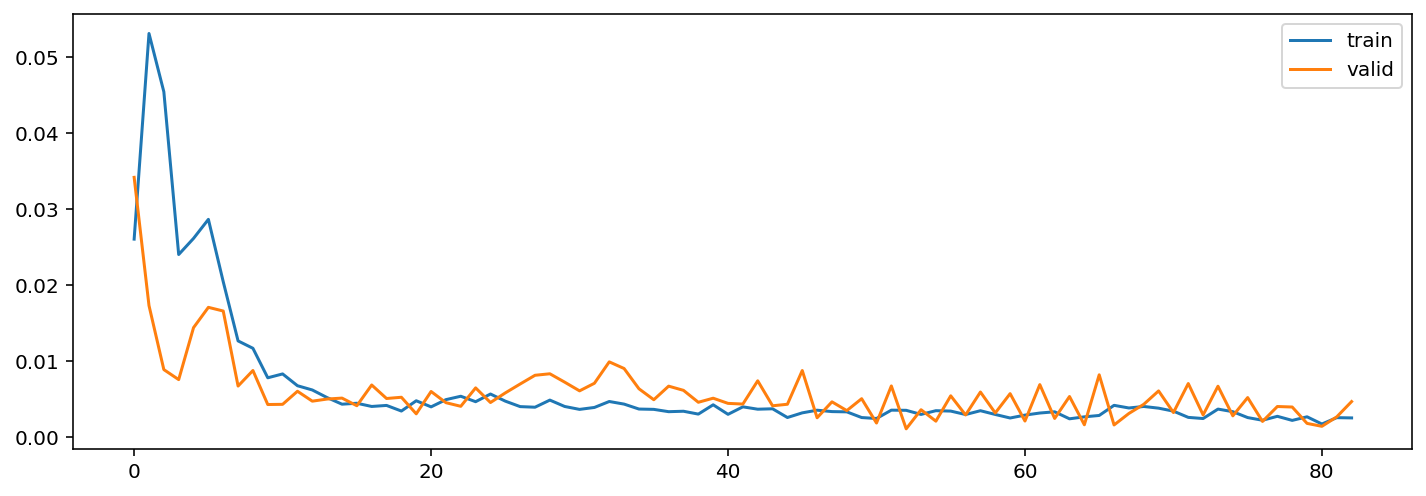

best epoch for valid set 52
best loss for valid set 0.001113051390892261
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.15 dropout_rate - 1 LSTM layers started..
Epoch 00109: early stopping
total time for learning: 245.7721667289734 sec


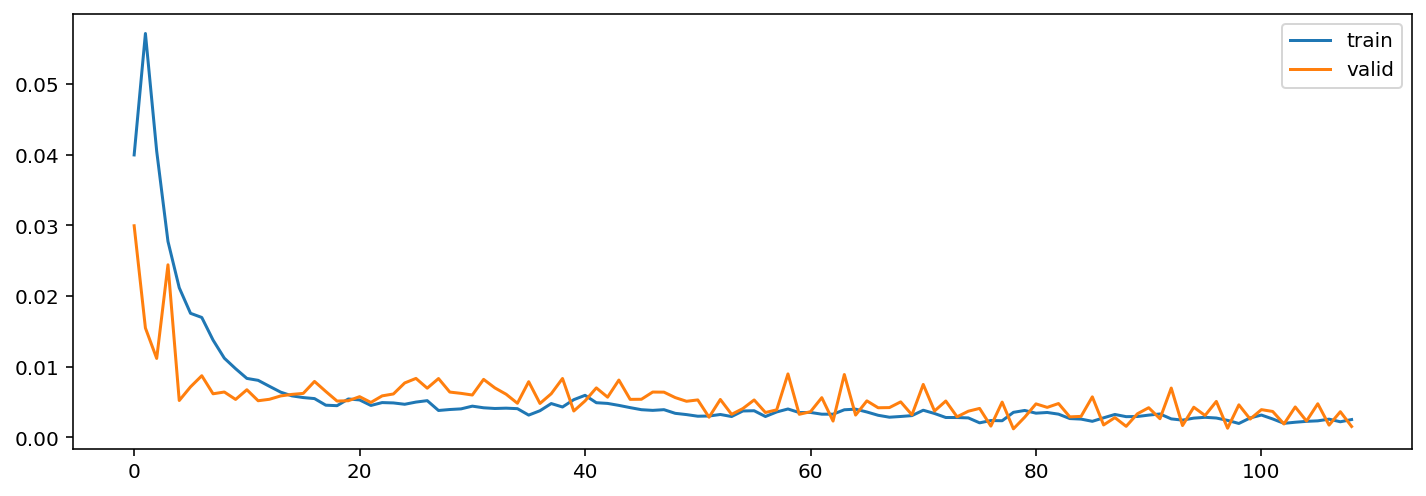

best epoch for valid set 78
best loss for valid set 0.001225305686587404
------------------------------------------------------------------------------------------
calculations for 128 nodes - 0.25 dropout_rate - 1 LSTM layers started..
Epoch 00045: early stopping
total time for learning: 104.38657736778259 sec


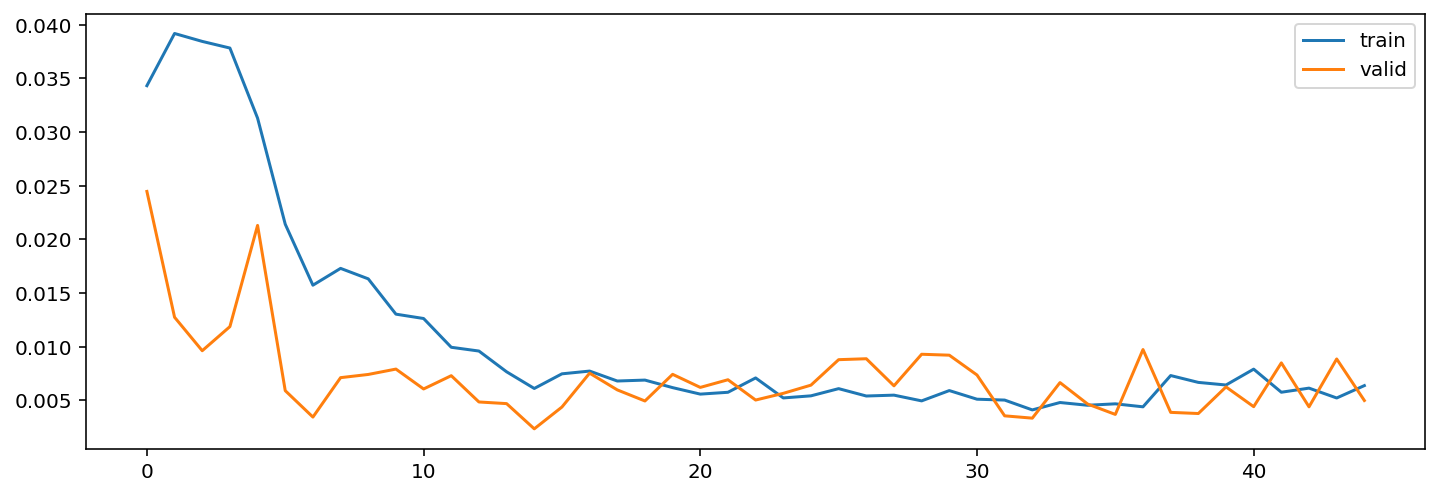

best epoch for valid set 14
best loss for valid set 0.002335471984418905
------------------------------------------------------------------------------------------


In [11]:
# 3.3. Calculating models for Cluster Center
# attention: this cell can take up to 1 hour with activated-GPU
# NOTICE: it is recommended to ignore this part

cluster_valid_losses, cluster_valid_epochs = [], []

param_grid = {t:dict(matrix_shape=cluster_train_tensor.shape[1:],
                    lstm_units=c[0],
                    dropout_rate=c[1],
                    n_internal_lstm=c[2]) 
              for t,c in zip(titles, combs)}


for title, params in param_grid.items():
    print(f'calculations for {title} started..')
    model = build_rnn_multiple_lstm(**params)
    history = fit_run_plot(model, cluster_train_tensor, cluster_train_target, n_epochs=150, batch_size=16, 
                           validation_split=0.15, verbose_mode=0, show_chart=True, display_total_time=True, 
                           display_model_summary=False, return_history=True, figsize=(12, 4), use_early_stopping=True)

    v_loss = np.array(history.history['val_loss'])
    
    cluster_valid_losses.append(v_loss.min())
    cluster_valid_epochs.append(v_loss.argmin())
        
    print(f"best epoch for valid set {v_loss.argmin()}")
    print(f"best loss for valid set {v_loss.min()}")
    print(f'-'*90)

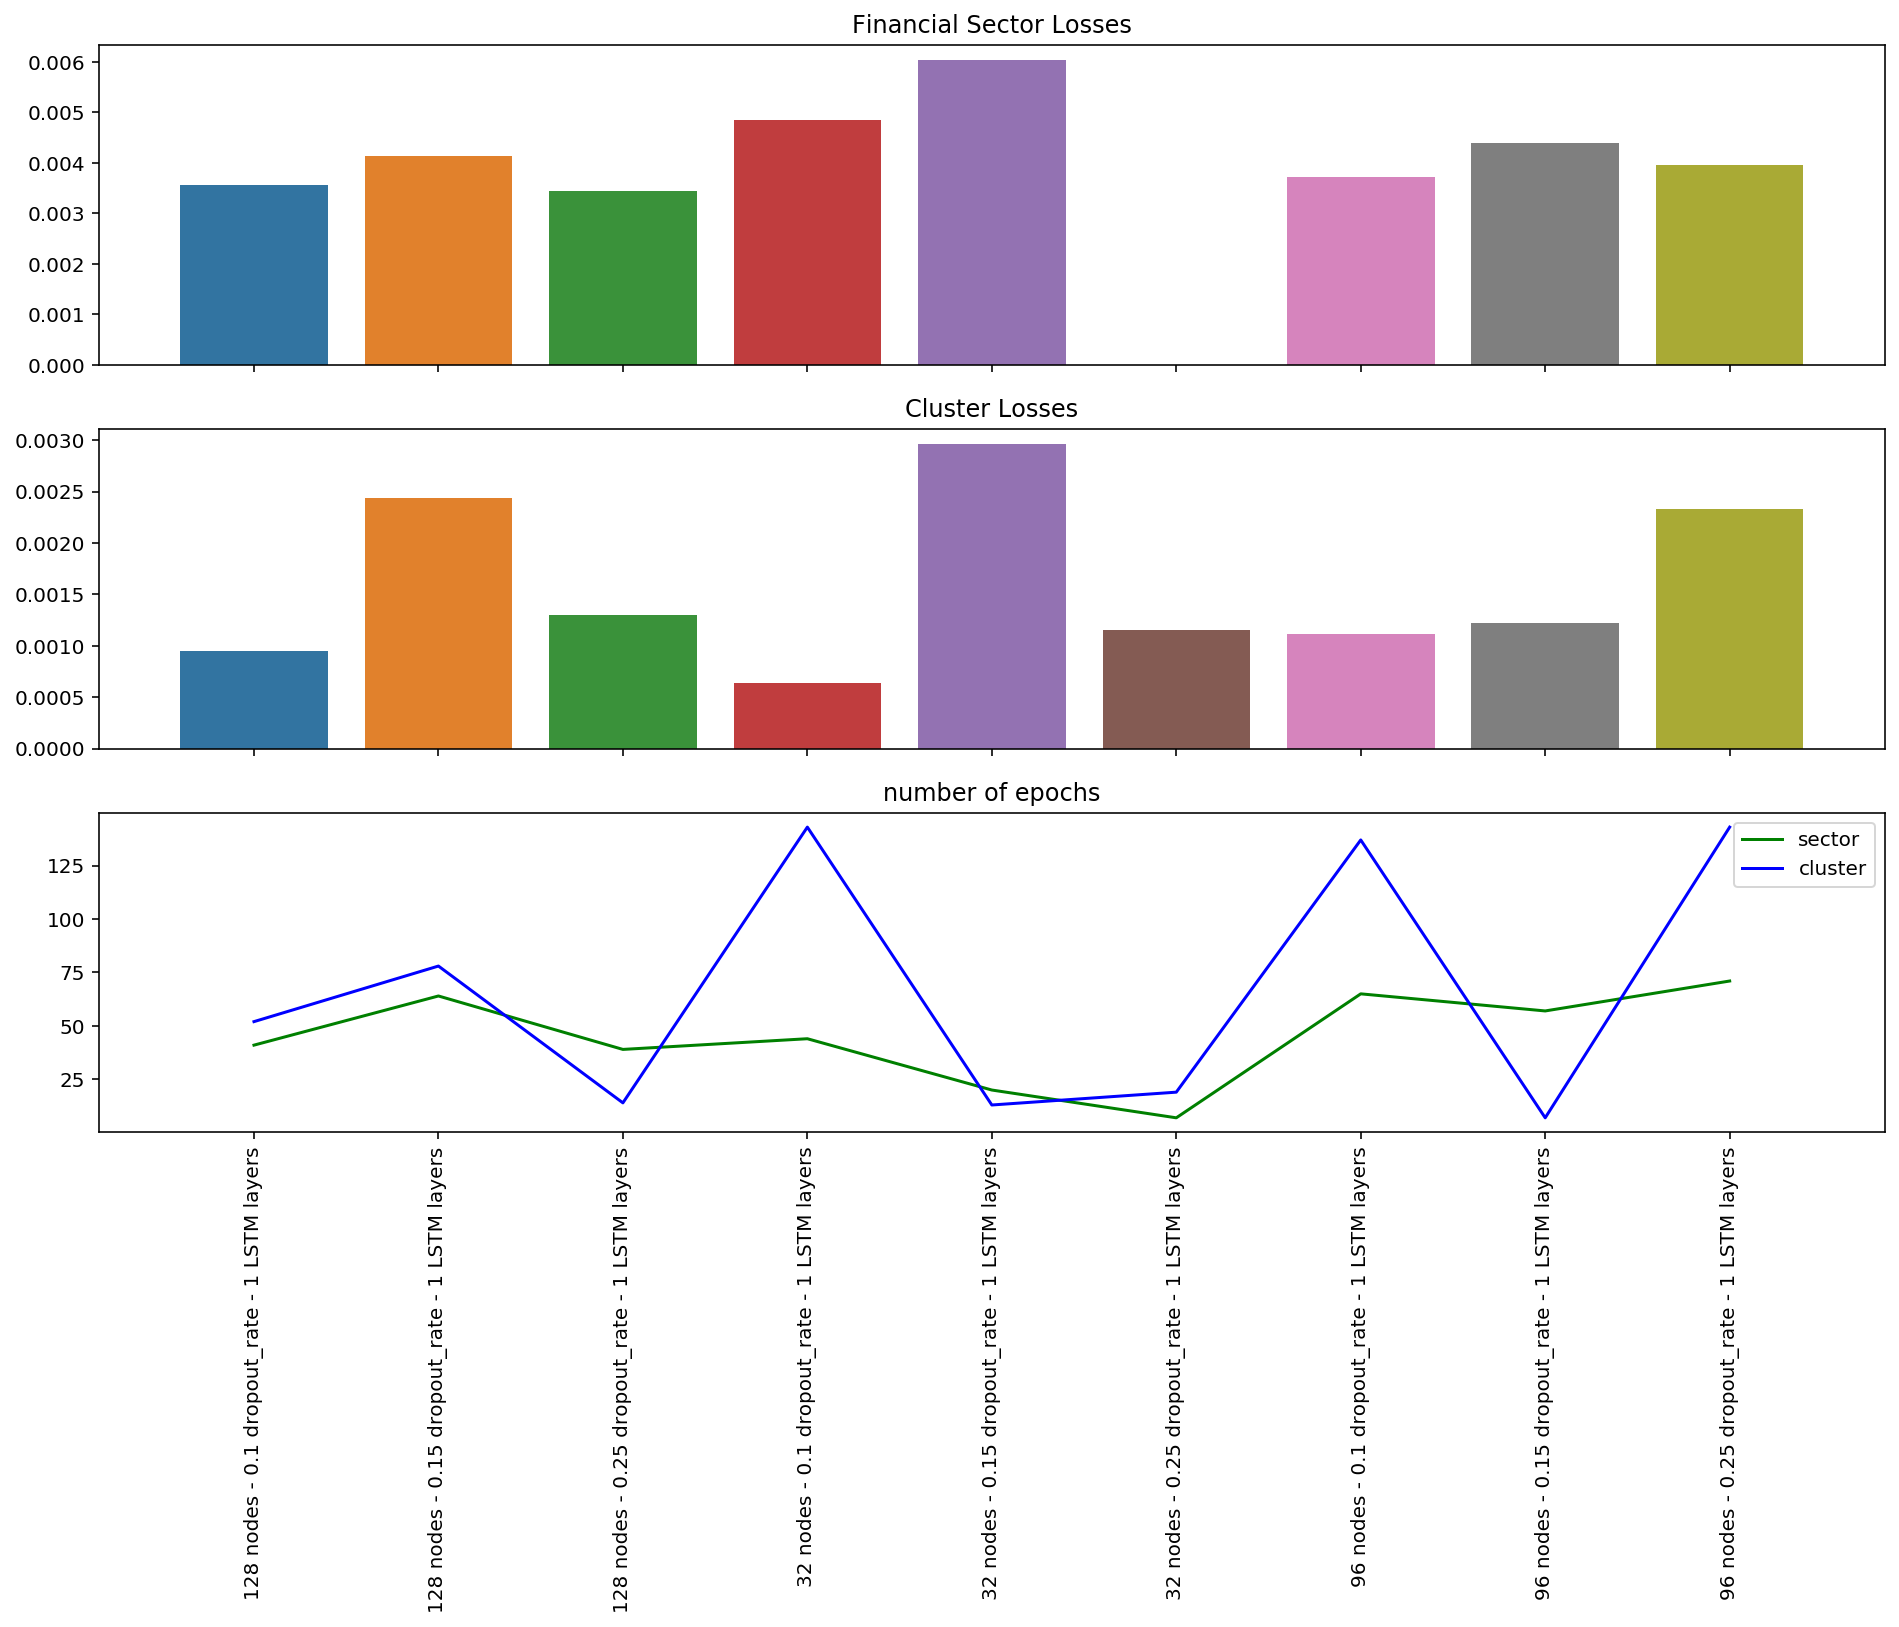

In [12]:
# 3.4. Result visualization
# NOTICE: it is recommended to ignore this part

fig, ax = plt.subplots(3,1, figsize=(16,10), sharex=True)
plt.xticks(rotation=90)
ax[0].set_title('Financial Sector Losses')
ax[1].set_title('Cluster Losses')
ax[2].set_title('number of epochs')

sns.barplot(x=titles,y=sector_valid_losses, ax=ax[0])
sns.barplot(x=titles,y=cluster_valid_losses, ax=ax[1])

sns.lineplot(x=titles,y=sector_valid_epochs, ax=ax[2], c='g', label='sector')
sns.lineplot(x=titles,y=cluster_valid_epochs, ax=ax[2], c='b', label='cluster')

plt.show()

- In general, most of all cases are comparable and close to each other
- From the above good stable results provided by 128 nodes in LSTM-layer case
- Best version for dropout rate is 0.10
- It is important to say, that in general, all calculation was done with early stopping callback which could underfit model, but it was done for time optimization

So, the following params were chosen for unified model architecture:
- LSTM - 1 layer with 128 neurons
- DropOut - 10%.

On next steps adding additional Full Dense hidden layer will be tested

calculations for hidden FC layer with 32 nodes started..
Epoch 00062: early stopping
total time for learning: 148.57968711853027 sec


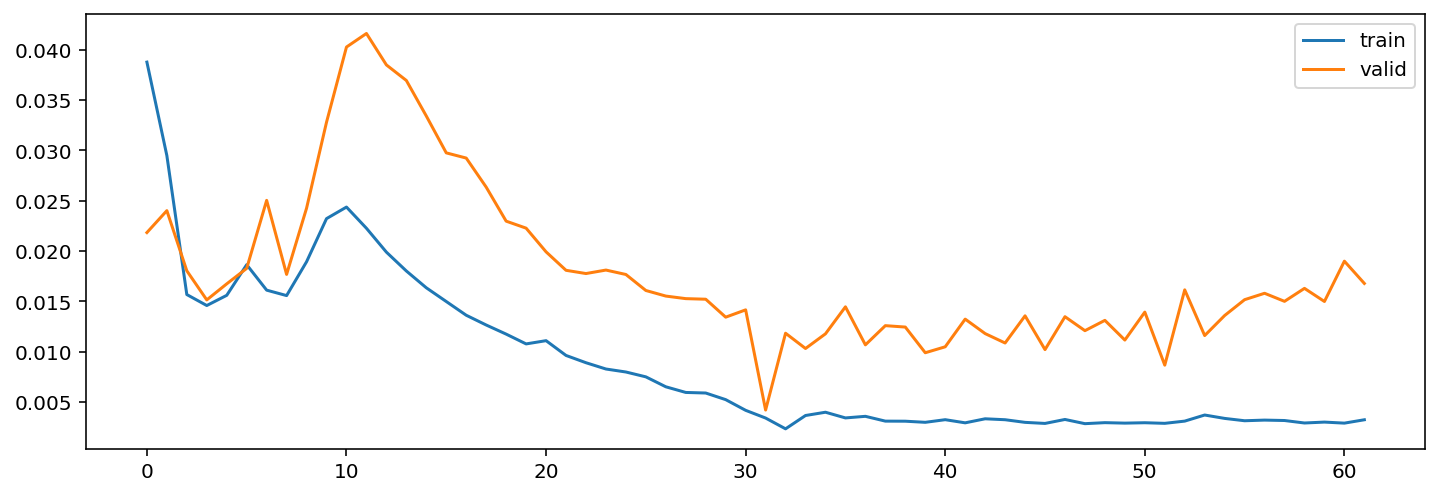

best epoch for valid set 31
best loss for valid set 0.004208175962468466
------------------------------------------------------------------------------------------
calculations for hidden FC layer with 90 nodes started..
Epoch 00104: early stopping
total time for learning: 238.79352498054504 sec


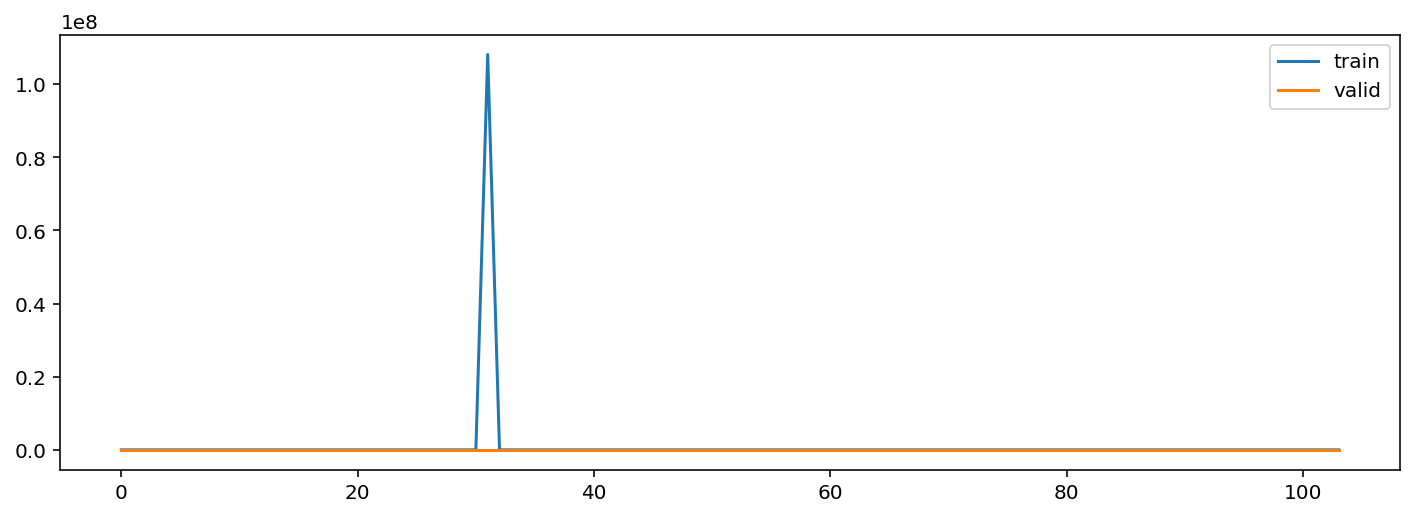

best epoch for valid set 73
best loss for valid set 0.0065652492941699475
------------------------------------------------------------------------------------------
calculations for hidden FC layer with 128 nodes started..
Epoch 00034: early stopping
total time for learning: 70.74372625350952 sec


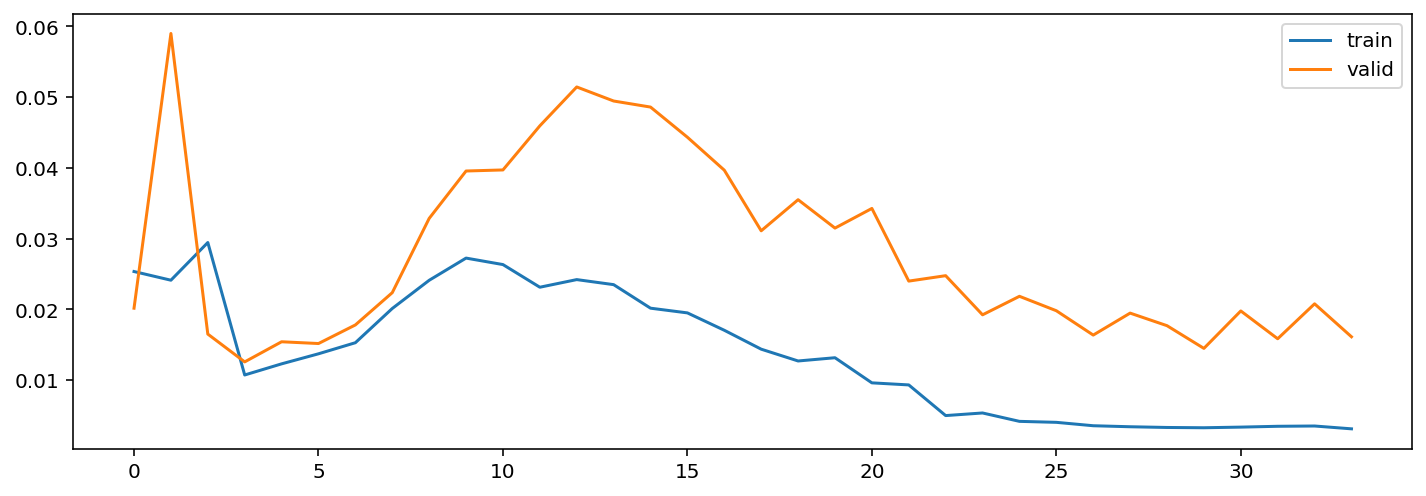

best epoch for valid set 3
best loss for valid set 0.01258067760786189
------------------------------------------------------------------------------------------


In [13]:
# 3.5. Calculating models for Sector. Hidden Full Dense Layer
# attention: this cell can take up to 12 minutes with activated-GPU
# NOTICE: it is recommended to ignore this part

lstm_n = [128]
dropout_rates = [0.1]
n_internal_lstm = [0]
full_dense = [True]
full_dense_nodes = [32, 90, 128]

combs = list(itertools.product(lstm_n, dropout_rates, n_internal_lstm, full_dense, full_dense_nodes))
titles_2 = ['hidden FC layer with '+str(i[4])+' nodes' for i in combs]

param_grid = {t:dict(matrix_shape=sector_train_tensor.shape[1:],
                    lstm_units=c[0],
                    dropout_rate=c[1],
                    n_internal_lstm=c[2],
                    add_internal_dense=c[3],
                    internal_dense_units=c[4])
              for t,c in zip(titles_2, combs)}

sector_valid_losses_2, sector_valid_epochs_2 = [], []

for title, params in param_grid.items():
    print(f'calculations for {title} started..')
    model = build_rnn_multiple_lstm(**params)
    history = fit_run_plot(model, sector_train_tensor, sector_train_target, n_epochs=150, batch_size=16, 
                           validation_split=0.15, verbose_mode=0, show_chart=True, display_total_time=True, 
                           display_model_summary=False, return_history=True, figsize=(12, 4), use_early_stopping=True)

    v_loss = np.array(history.history['val_loss'])
    
    sector_valid_losses_2.append(v_loss.min())
    sector_valid_epochs_2.append(v_loss.argmin())
    
    print(f"best epoch for valid set {v_loss.argmin()}")
    print(f"best loss for valid set {v_loss.min()}")
    print(f'-'*90)

calculations for hidden FC layer with 32 nodes started..
Epoch 00075: early stopping
total time for learning: 160.5889332294464 sec


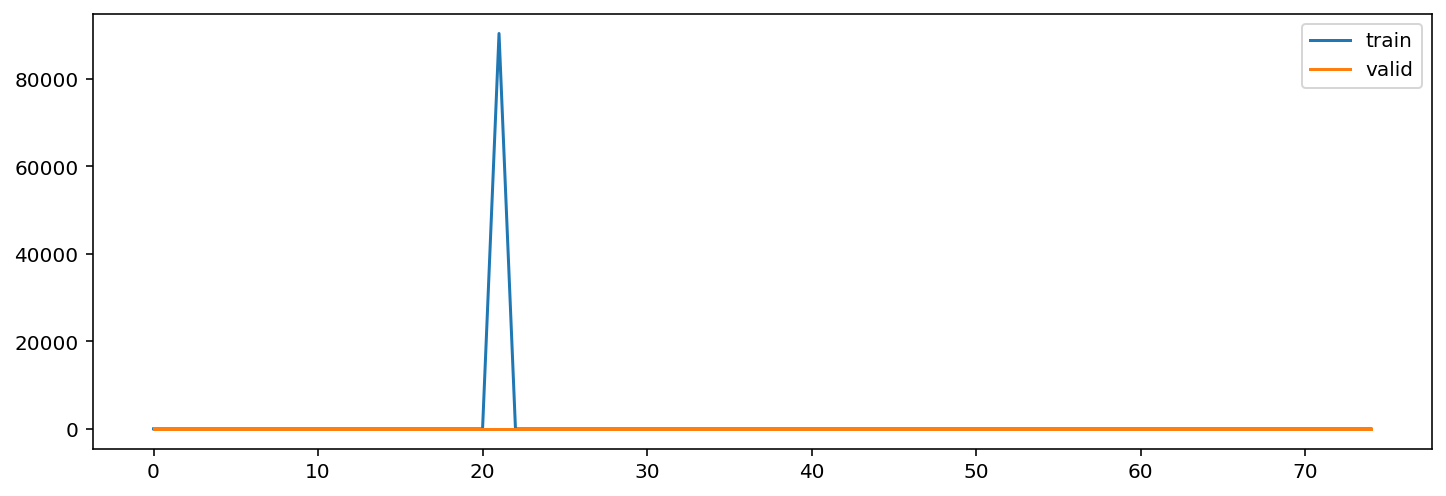

best epoch for valid set 44
best loss for valid set 0.0012942679210478424
------------------------------------------------------------------------------------------
calculations for hidden FC layer with 90 nodes started..
Epoch 00088: early stopping
total time for learning: 182.7069957256317 sec


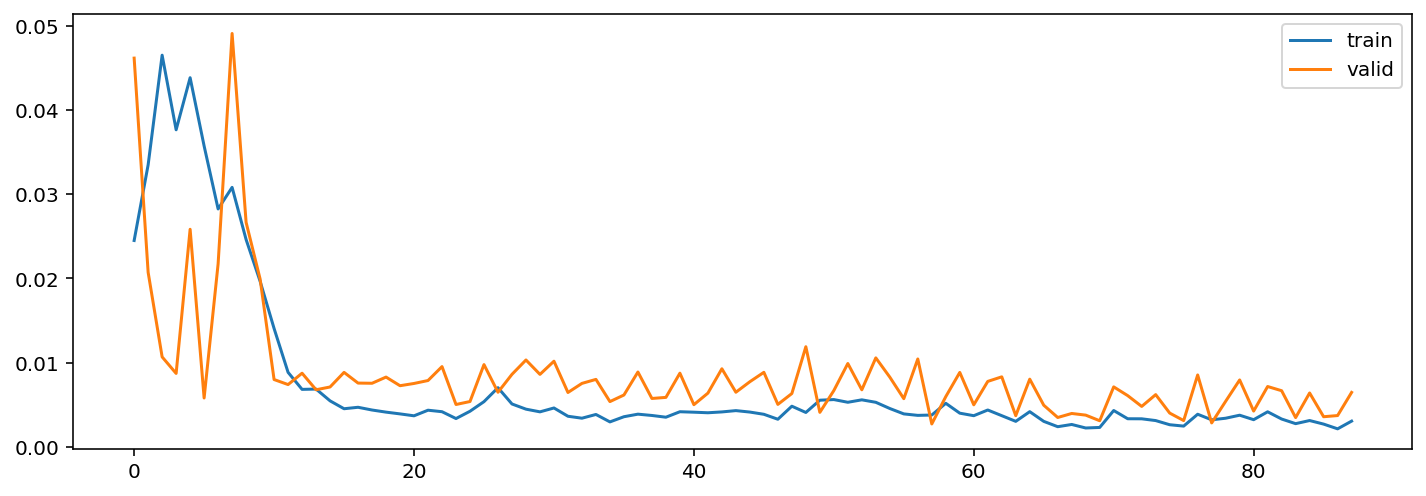

best epoch for valid set 57
best loss for valid set 0.00272799584055399
------------------------------------------------------------------------------------------
calculations for hidden FC layer with 128 nodes started..
total time for learning: 309.1256203651428 sec


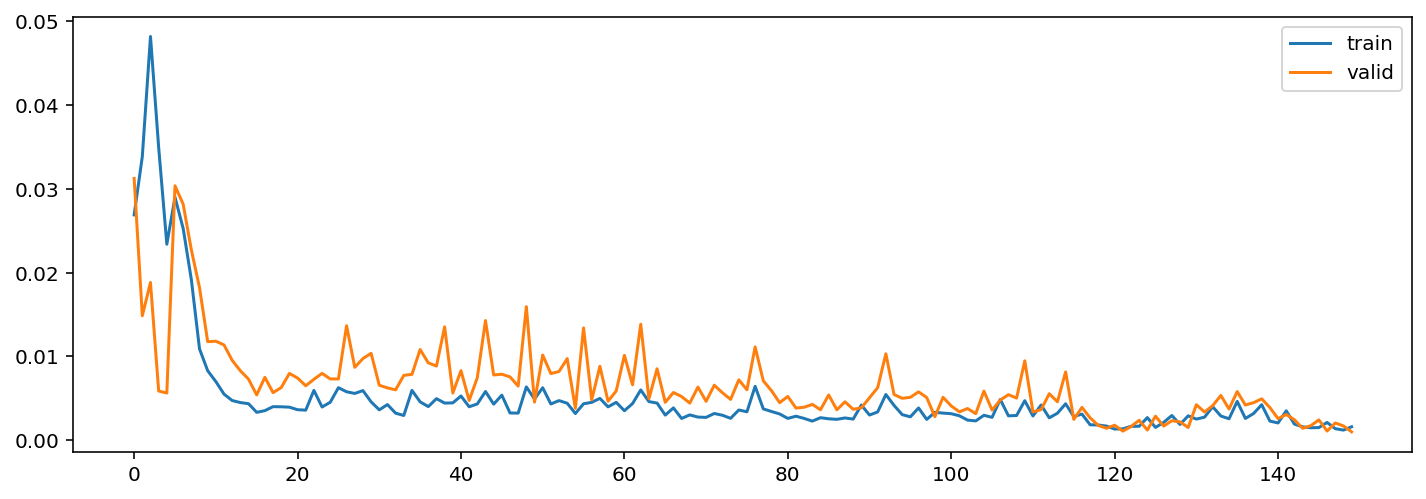

best epoch for valid set 149
best loss for valid set 0.000975204071499662
------------------------------------------------------------------------------------------


In [14]:
# 3.6. Calculating models for Cluster Center. Hidden Full Dense Layer
# attention: this cell can take up to 12 minutes with activated-GPU
# NOTICE: it is recommended to ignore this part

cluster_valid_losses_2, cluster_valid_epochs_2 = [], []

for title, params in param_grid.items():
    print(f'calculations for {title} started..')
    model = build_rnn_multiple_lstm(**params)
    history = fit_run_plot(model, cluster_train_tensor, cluster_train_target, n_epochs=150, batch_size=16, 
                           validation_split=0.15, verbose_mode=0, show_chart=True, display_total_time=True, 
                           display_model_summary=False, return_history=True, figsize=(12, 4), use_early_stopping=True)

    v_loss = np.array(history.history['val_loss'])
    cluster_valid_losses_2.append(v_loss.min())
    cluster_valid_epochs_2.append(v_loss.argmin())
    
    print(f"best epoch for valid set {v_loss.argmin()}")
    print(f"best loss for valid set {v_loss.min()}")
    print(f'-'*90)

In [10]:
# 3.7. Final Model Architecture. CHECKPOINT
rnn_params = dict(
                  lstm_units=128, lstm_activation='relu', use_dropout=True, dropout_rate=0.10, 
                  n_internal_lstm=0, add_internal_dense=False, optimizer='adam', 
                  loss_function='mse', show_model_layers=False
                    )

So, adding hidden FC layer do not improve models.  
Final chosen architecture:
- 1-LSTM(128) - DropOut(0.10) -  FC(1)

Optimal params saved to `rnn_params` dict

#### Fitting models Stage

In this part models for all time series will be fitted.  
Fitting process include 2 phases:
- phase 1. Created history object with 150 epochs
- phase 2. Optimal epoch number defined for each model (based on valid loss), and after the model refit with this epoch number (with `return_history`=False parameter)
  - in this case I don't use ModelCheckPoint and EarlyStopping, since time series are not so big and fitting process takes reasonable amount of time


- fitted models saved to `models` folder


- only 4.1. part of code is required for next steps, other parts were commented since they takes up to 4 hours
  - all fitted models loaded in part 5 at 5.1. CHECKPOINT

In [198]:
# 4.1. data preparation for all composites and cluster centers

sector_scaled_dict = dict()

for comp in sector_composite_norm.columns:
    df = pd.DataFrame(sector_composite_norm[comp])
    df = add_period_cols(df)
    try:
        df = df.drop(columns=['day_of_week'], axis=1)
    except Exception:
        pass
    df_train, df_test = split_to_train_test(df, test_portion=0.2)
    df_train_scaled, df_test_scaled, df_scaler, df_scaler_target = scale_data(MinMaxScaler(), df_train, df_test, 
                                                                              target_name=comp, show_stats=False)
    
    sector_scaled_dict[comp] = (df_train_scaled, df_test_scaled, df_scaler, df_scaler_target)
    
cluster_scaled_dict = dict()

for comp in cluster_composite_norm.columns:
    df = pd.DataFrame(cluster_composite_norm[comp])
    df = add_period_cols(df)
    try:
        df = df.drop(columns=['day_of_week'], axis=1)
    except Exception:
        pass
    df_train, df_test = split_to_train_test(df, test_portion=0.2)
    df_train_scaled, df_test_scaled, df_scaler, df_scaler_target = scale_data(MinMaxScaler(), df_train, df_test, 
                                                                                target_name=comp, show_stats=False)
    
    cluster_scaled_dict[comp] = (df_train_scaled, df_test_scaled, df_scaler, df_scaler_target)    

    
with open('datasets_4_modelling/scaled_splitted_sectors.pkl', 'wb') as f:
    pickle.dump(sector_scaled_dict, f)

with open('datasets_4_modelling/scaled_splitted_clusters.pkl', 'wb') as f:
    pickle.dump(cluster_scaled_dict, f)

In [17]:
# 4.2. Fitting models for sector composites
# early stopping - switched off
# attention: this cell can take up to 1.5 hour with GPU-version on calculation

#sector_models_fitted = dict()

#idx = 0
#start_time = time.time()

#for comp in sector_scaled_dict:
#    idx += 1
#    target = comp
#    print(f'{target} started ...')
    
#    df_train = sector_scaled_dict[comp][0]
    
#    train_tensor, train_target = create_tensor(df_train, df_train[target], window_size=90, show_shape=False)
#    model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **rnn_params)
#    history = fit_run_plot(model, train_tensor, train_target, n_epochs=130, batch_size=16, 
#                               validation_split=0.15, verbose_mode=0, show_chart=False, display_total_time=False, 
#                               display_model_summary=False, return_history=True, use_early_stopping=False)
    
#    epoch_step = np.array(history.history['val_loss']).argmin()
#    v_loss = np.array(history.history["val_loss"]).min()
#    print(f'optimum epochs number {epoch_step} with val loss = {v_loss}')
    
#    final_model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **rnn_params)
#    final_model = fit_run_plot(final_model, train_tensor, train_target, n_epochs=epoch_step, batch_size=16, 
#                               validation_split=0.01, verbose_mode=0, show_chart=False, display_total_time=False, 
#                               display_model_summary=False, return_history=False, use_early_stopping=False)
    
#    sector_models_fitted[comp] = final_model
    
#    print(f'...{idx} of {len(sector_scaled_dict)} finished in {(time.time() - start_time):.0f} sec')
#    print(50*'-')
#    start_time = time.time()

In [18]:
# 4.3. Fitting models for cluster centers
# early stopping - switched off
# attention: this cell can take up to 2 hours with GPU-version on calculation

#cluster_models_fitted = dict()

#idx = 0
#start_time = time.time()

#for comp in cluster_scaled_dict:
#    idx += 1
#    target = comp
#    print(f'{target} started ...')
    
#    df_train = cluster_scaled_dict[comp][0]
    
#    train_tensor, train_target = create_tensor(df_train, df_train[target], window_size=90, show_shape=False)
#    model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **rnn_params)
#    history = fit_run_plot(model, train_tensor, train_target, n_epochs=130, batch_size=16, 
#                               validation_split=0.15, verbose_mode=0, show_chart=False, display_total_time=False, 
#                               display_model_summary=False, return_history=True, use_early_stopping=False)
    
#    epoch_step = np.array(history.history['val_loss']).argmin()
#    v_loss = np.array(history.history["val_loss"]).min()
    
#    print(f'optimum epochs number {epoch_step} with val loss = {v_loss}')
#    final_model = build_rnn_multiple_lstm(matrix_shape=train_tensor.shape[1:], **rnn_params)
#    final_model = fit_run_plot(final_model, train_tensor, train_target, n_epochs=epoch_step, batch_size=16, 
#                               validation_split=0.01, verbose_mode=0, show_chart=False, display_total_time=False, 
#                               display_model_summary=False, return_history=False, use_early_stopping=False)
    
#    cluster_models_fitted[comp] = final_model
    
#    print(f'...{idx} of {len(cluster_scaled_dict)} finished in {(time.time() - start_time):.0f} sec')
#    print(50*'-')
#    start_time = time.time()

In [19]:
# 4.4. Saving models
# already done, code commented

#for name, model in sector_models_fitted.items():
#    path = f'models/{name}_v1.h5'
#    model.save(path)

#for name, model in cluster_models_fitted.items():
#    path = f'models/{name}_v1.h5'
#    model.save(path)


#### Forecasting: Visual Analysis and R2 score

In this part I will test fitted models on TEST timeline for each time series and visualize 1-step-ahed forecast charts

In [218]:
# 5.1. CHECKPOINT. loading models to dict
model_names = os.listdir('models')
models_to_drop = ['NBTB_fs.h5', 'NBTB_simple.h5'] # these models are from PART 7 (not for this notebook)
model_names.remove(models_to_drop[0])
model_names.remove(models_to_drop[1])

loaded_models = [load_model('models/'+m) for m in model_names]

sector_models, cluster_models = dict(), dict()

for name, model in zip(model_names, loaded_models):
    name_short = name[:-6]
    if name_short in list(sector_scaled_dict.keys()):
        sector_models[name_short] = model
    elif name_short in list(cluster_scaled_dict.keys()):
        cluster_models[name_short] = model

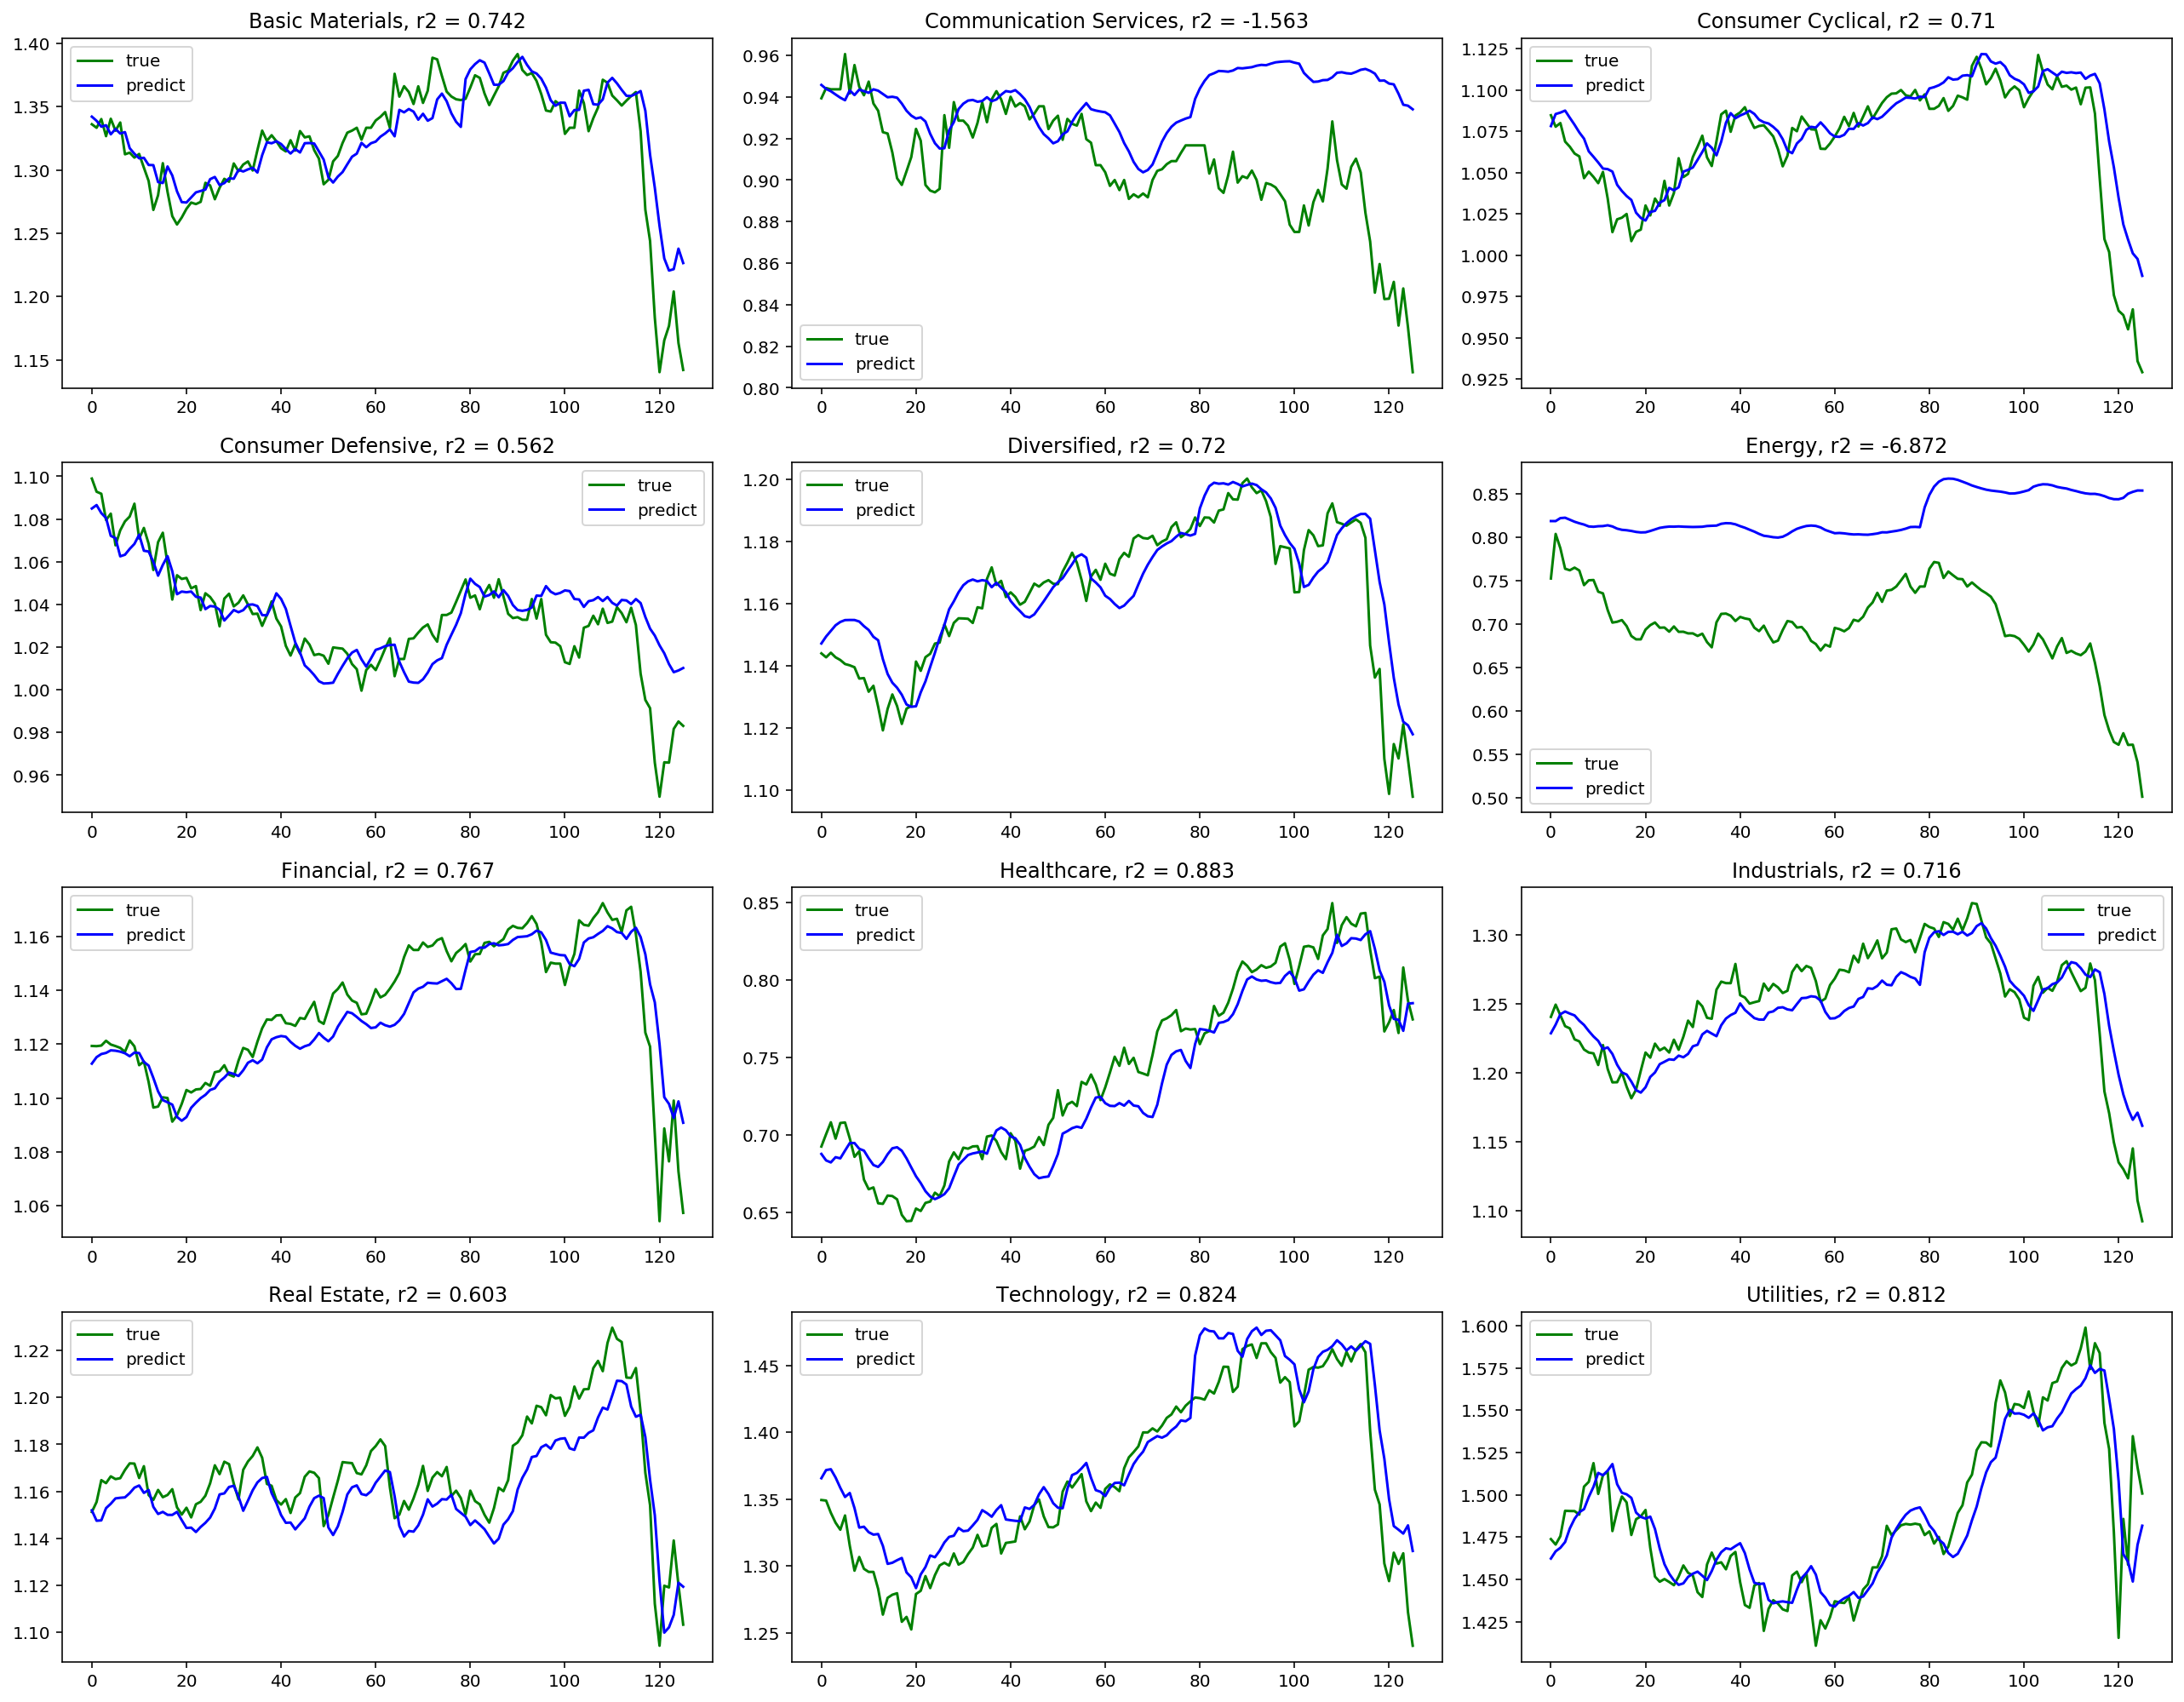

In [221]:
# 5.2. Visualizing 1-step forecast for sectors on TEST data

rows, cols = range(4), range(3)
idx = 0

fig, ax = plt.subplots(4,3, figsize=(18,14))
for r in rows:
    for c in cols:
        target = list(sector_models.keys())[idx]
        model = sector_models[target]
        train, test, scaler, scaler_target = sector_scaled_dict[target]
        test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)
        pred, true = forecast_1step_rnn(fitted_model=model, scaler_target=scaler_target, test_tensor=test_tensor,
                                       test_scaled=test, target_name=target, plot_chart=False)
        
        r2 = round(r2_score(true, pred),3)
        ax[r][c].set_title(f'{target}, r2 = {r2}')
        ax[r][c].plot(true, c='g', label='true')
        ax[r][c].plot(pred, c='b', label='predict')
        ax[r][c].legend(loc='best')
        idx += 1

plt.tight_layout()
plt.show()

As it shown above, all models except Communication Services and Energy have moderate and good level of r2 which varies from 0.56 to 0.88.

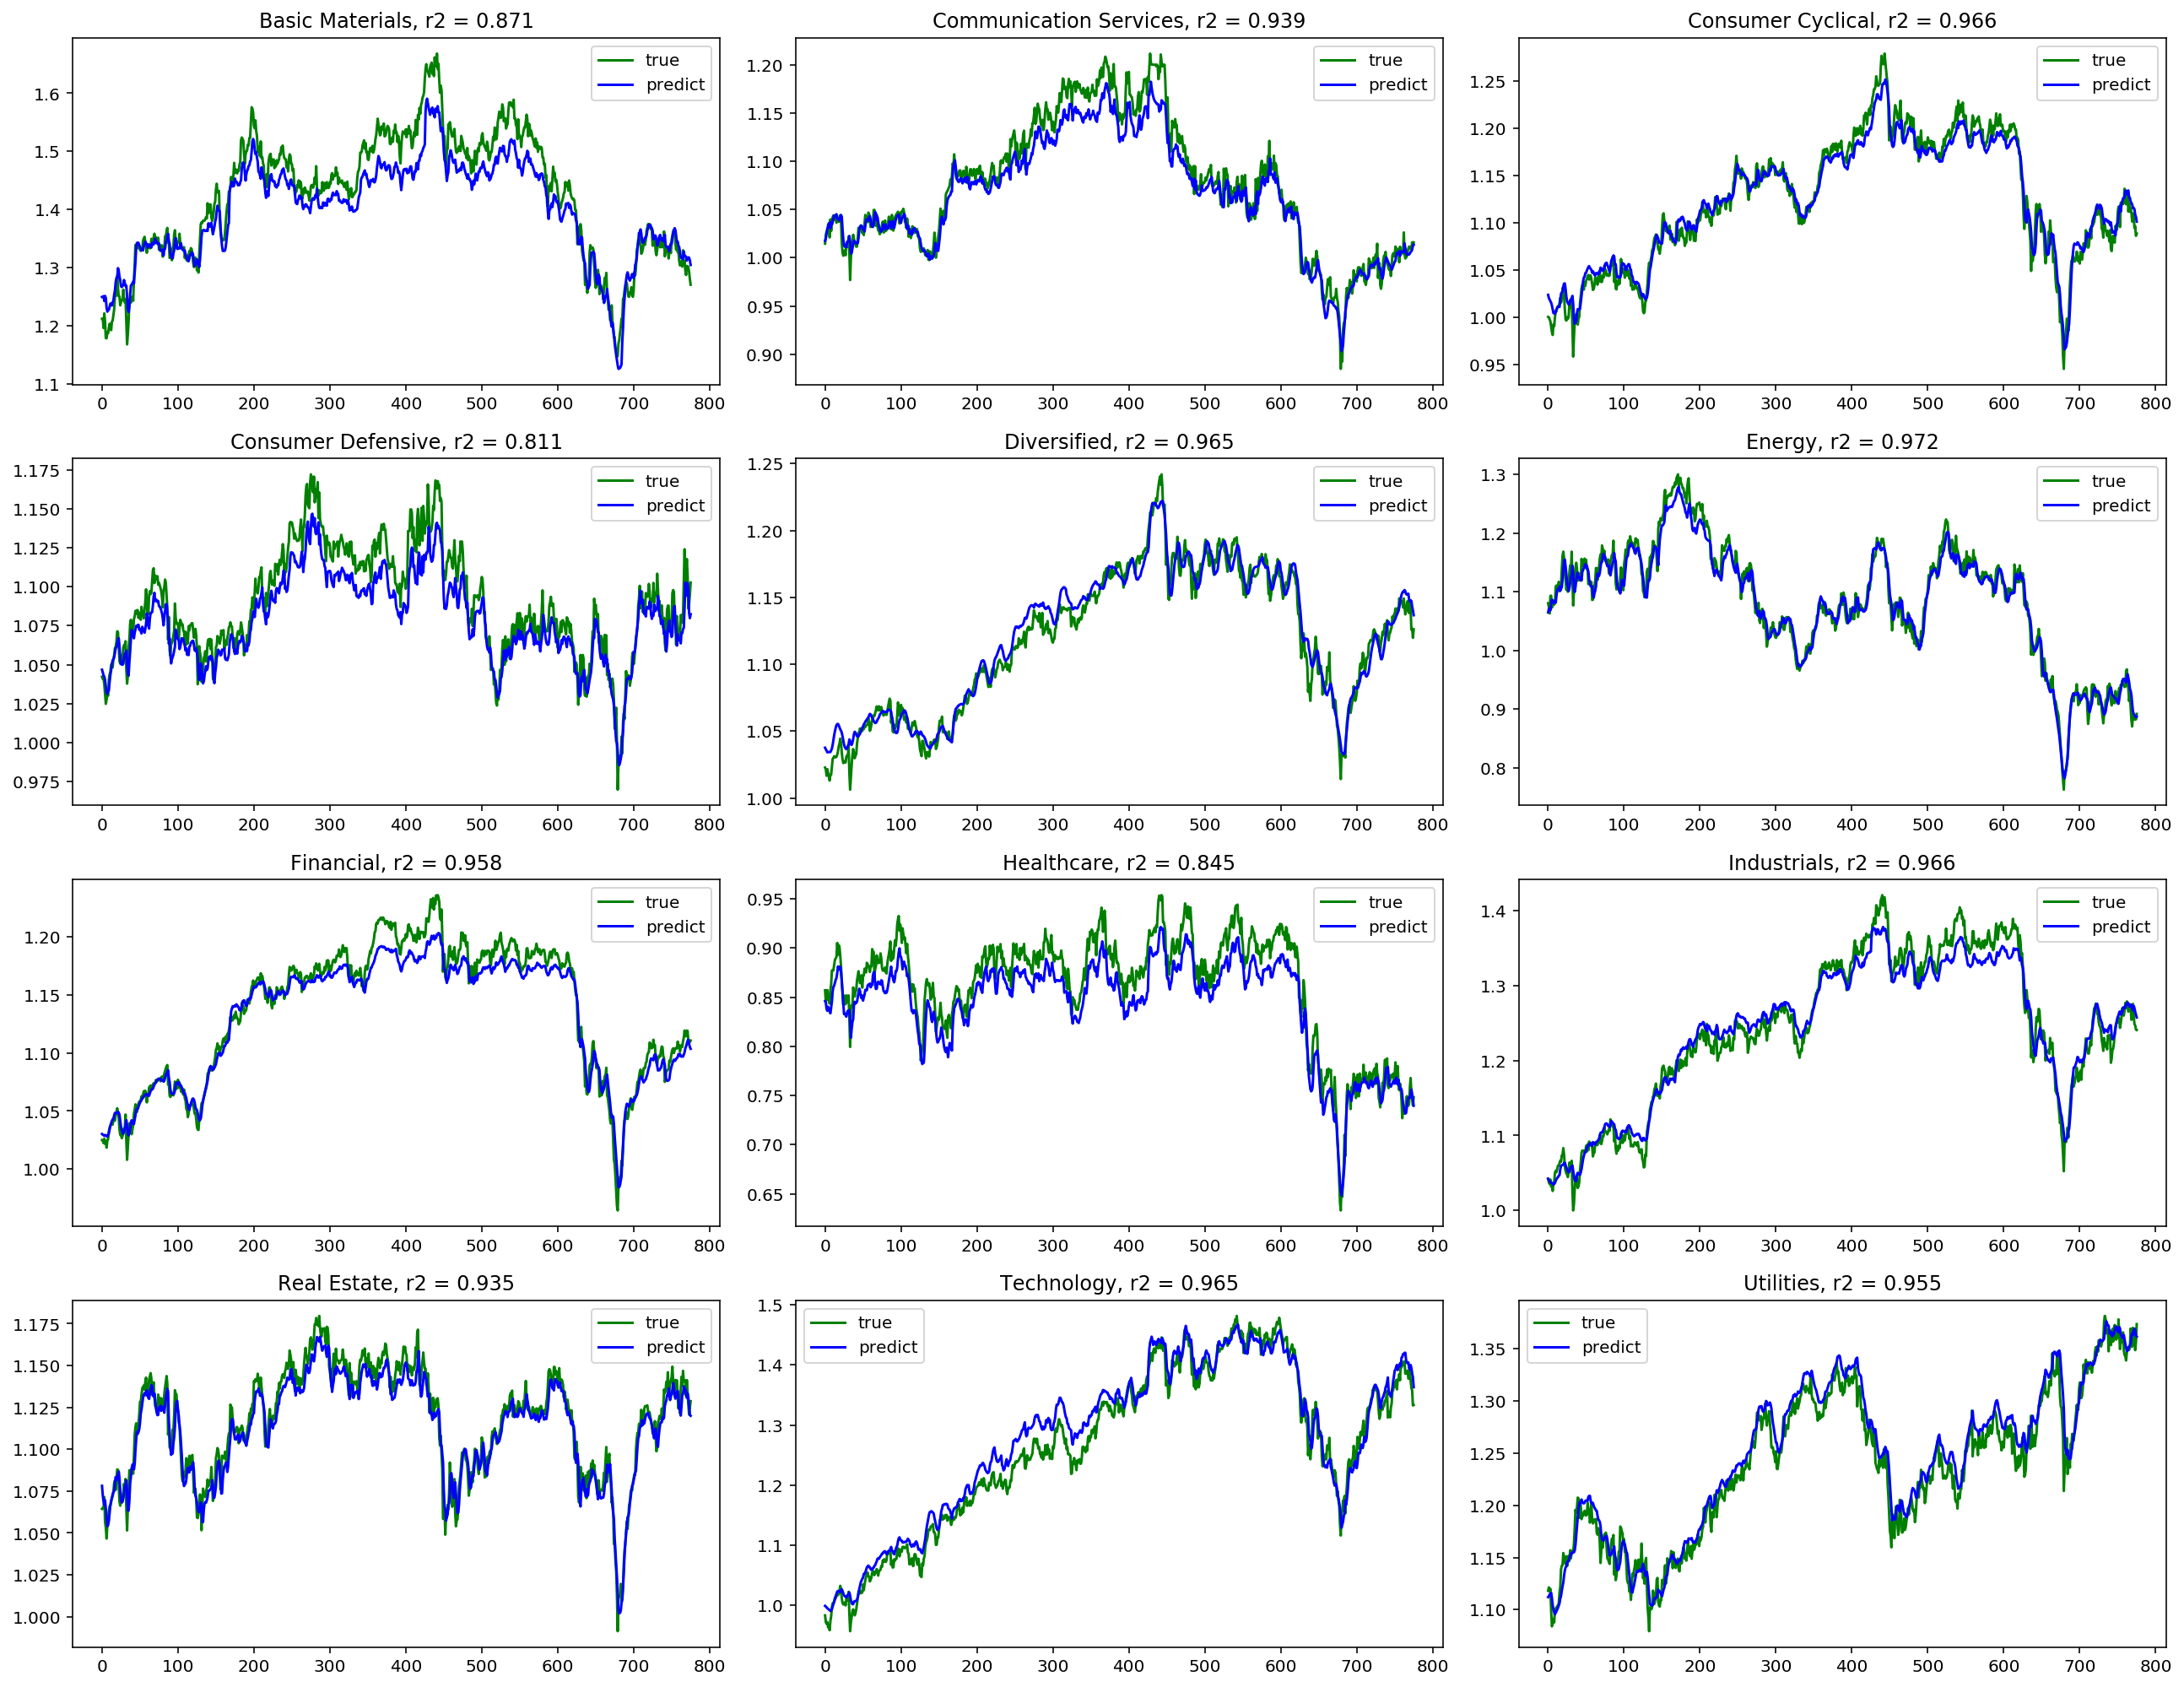

In [222]:
# 5.3. Visualizing 1-step forecast for sectors on TRAIN data

rows, cols = range(4), range(3)
idx = 0

fig, ax = plt.subplots(4,3, figsize=(18,14))
for r in rows:
    for c in cols:
        target = list(sector_models.keys())[idx]
        model = sector_models[target]
        train, test, scaler, scaler_target = sector_scaled_dict[target]
        train_tensor, train_target = create_tensor(train, train[target], window_size=90, show_shape=False)
        pred, true = forecast_1step_rnn(fitted_model=model, scaler_target=scaler_target, test_tensor=train_tensor,
                                       test_scaled=train, target_name=target, plot_chart=False)
        
        r2 = round(r2_score(true, pred),3)
        ax[r][c].set_title(f'{target}, r2 = {r2}')
        ax[r][c].plot(true, c='g', label='true')
        ax[r][c].plot(pred, c='b', label='predict')
        ax[r][c].legend(loc='best')
        idx += 1

plt.tight_layout()
plt.show()

Results from TRAIN data are higher and r2 varies from 0.81 to 0.97, which is comparable with ARIMA-models.  
Now, let's evaluated r2 for test data on cluster centers

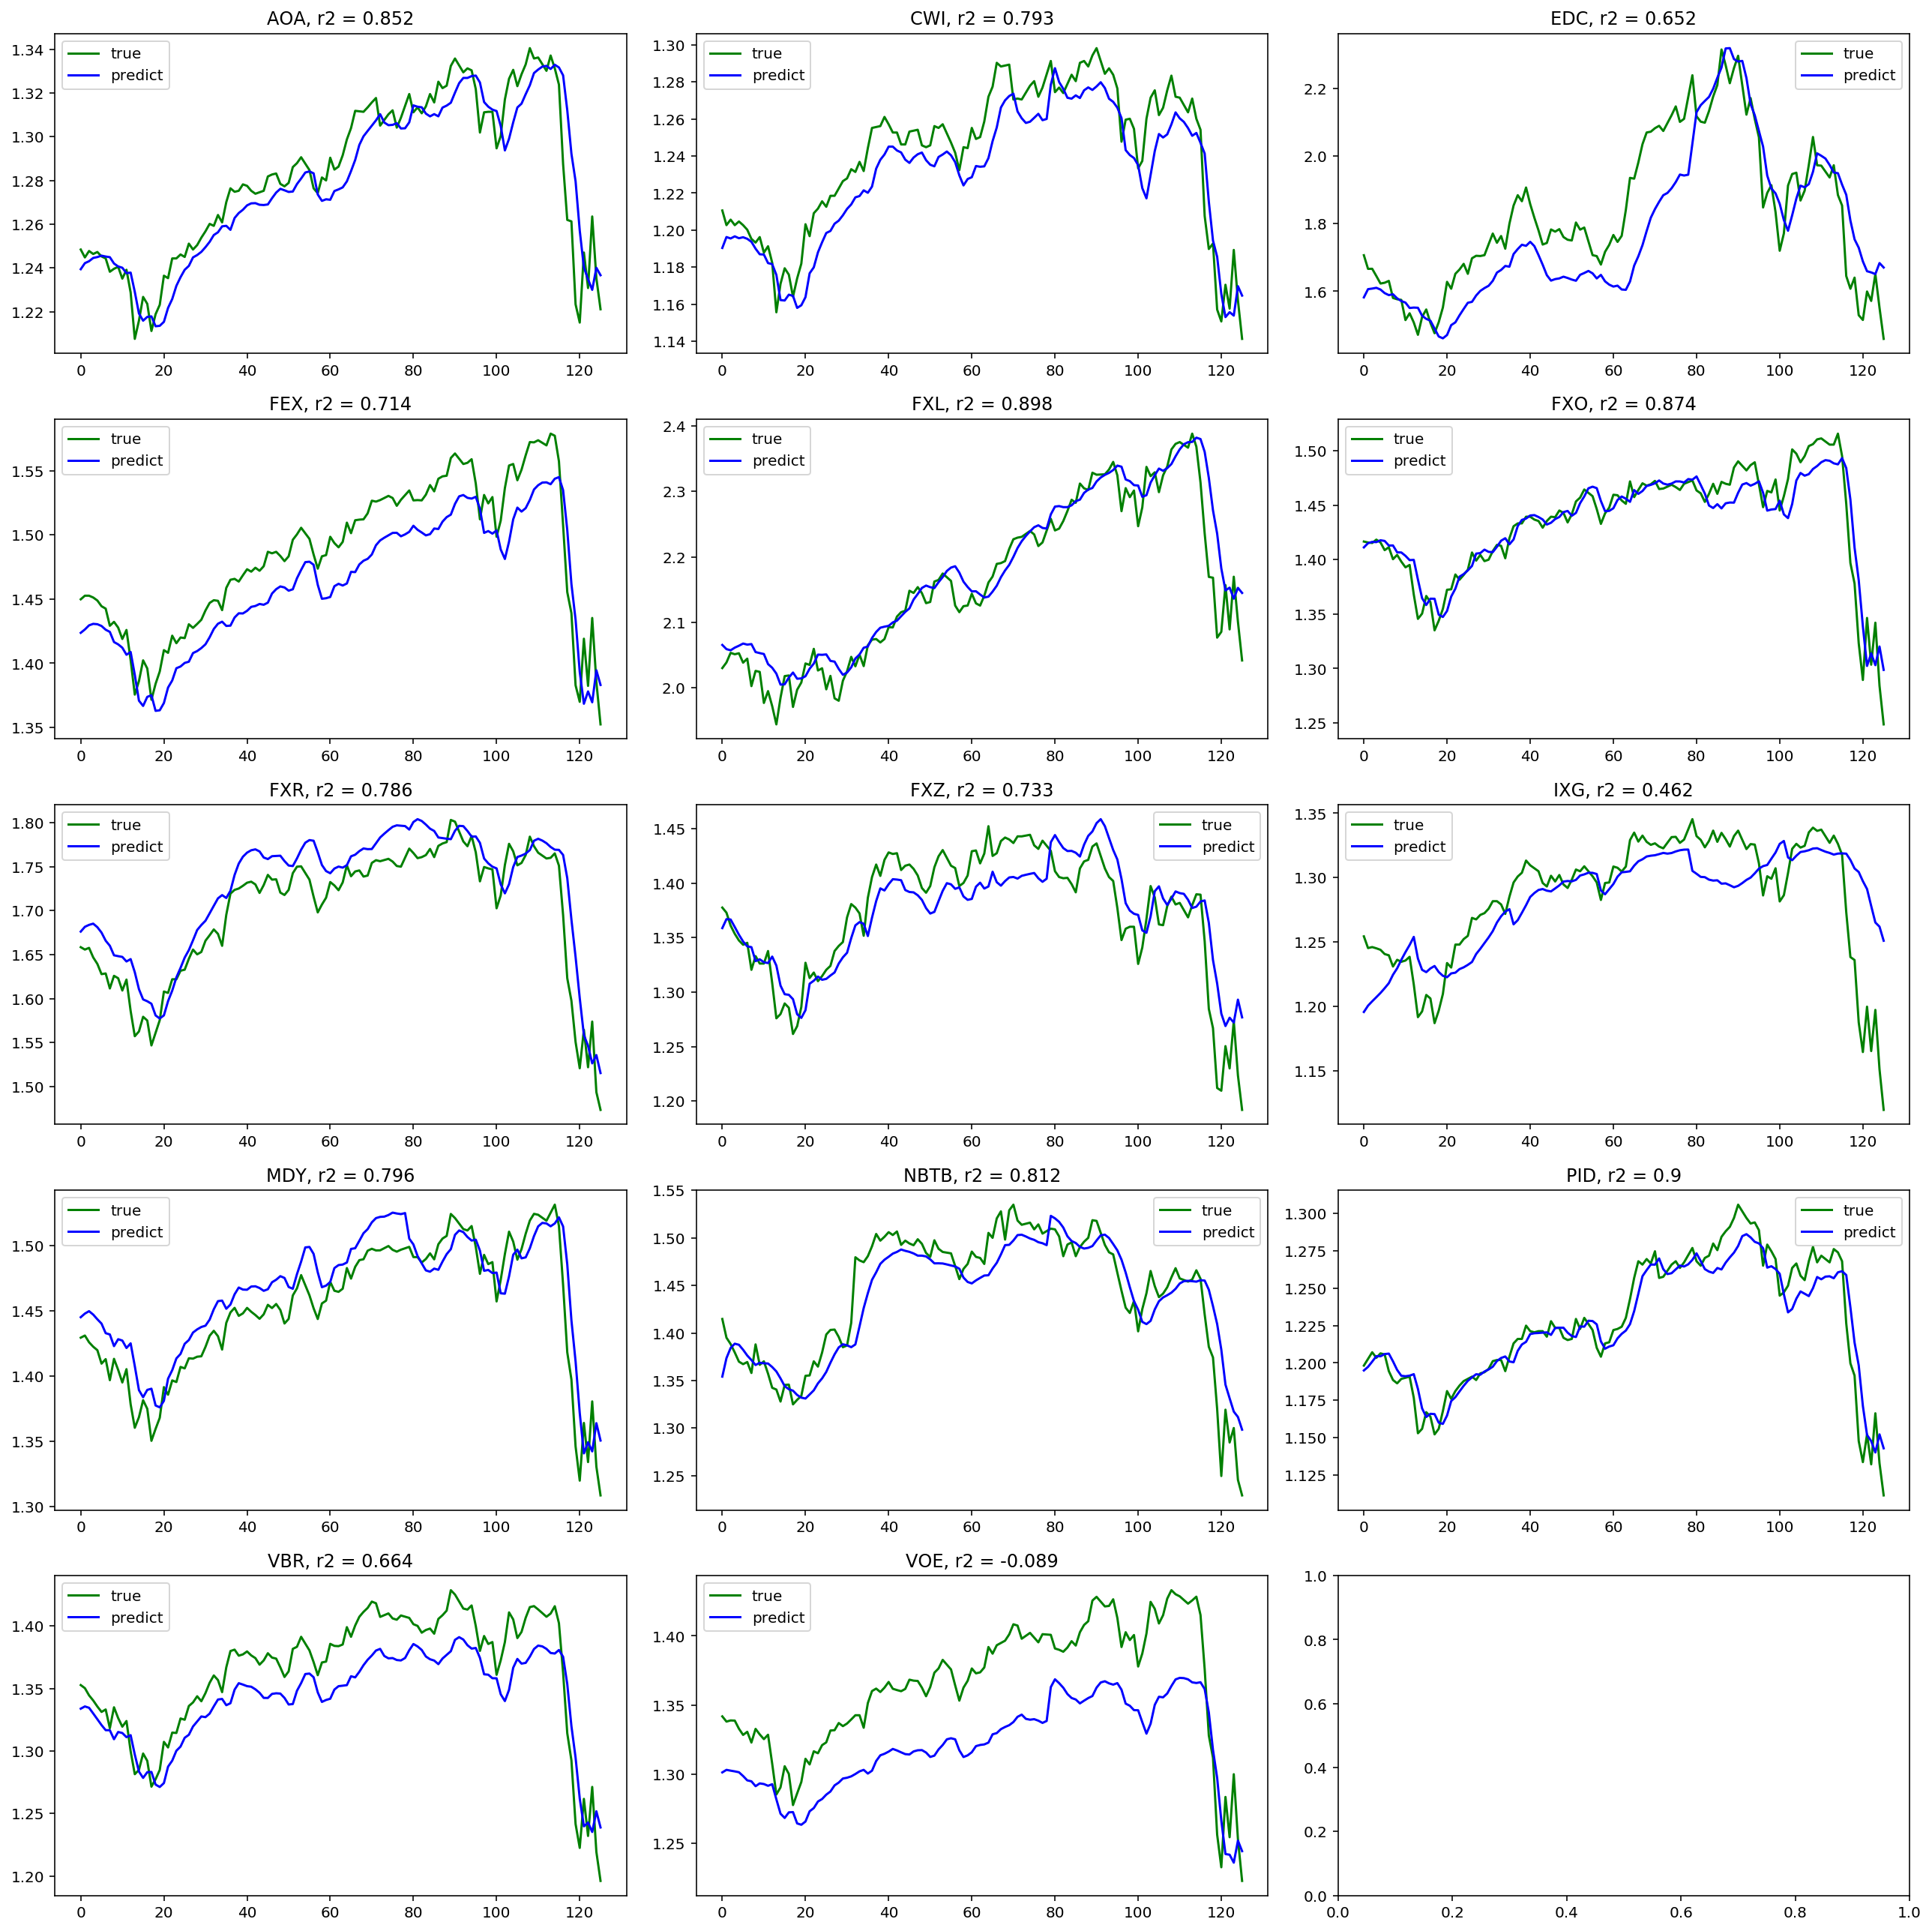

In [223]:
# 5.4. Visualizing 1-step forecast for CLUSTER CENTERS on TEST data

rows, cols = range(5), range(3)
idx = 0

fig, ax = plt.subplots(5,3, figsize=(18,18))
for r in rows:
    for c in cols:
        if idx < 14:
            target = list(cluster_models.keys())[idx]
            model = cluster_models[target]
            train, test, scaler, scaler_target = cluster_scaled_dict[target]
            test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)
            pred, true = forecast_1step_rnn(fitted_model=model, scaler_target=scaler_target, test_tensor=test_tensor,
                                           test_scaled=test, target_name=target, plot_chart=False)

            r2 = round(r2_score(true, pred),3)
            ax[r][c].set_title(f'{target}, r2 = {r2}')
            ax[r][c].plot(true, c='g', label='true')
            ax[r][c].plot(pred, c='b', label='predict')
            ax[r][c].legend(loc='best')
            idx += 1

plt.tight_layout()
plt.show()

Excluding VOE и IXG, results are stable and robust, r2 varies from 0.65 to 0.90

#### Long-Term forecasting (full-cycle)

The specificity of time series forecasting, both in ARIMA models and in RNN, is that the previous values of the predicted value are simultaneously one of the features for target. This leads to the fact that even in conditions of using the model on test datasets (as it was above), in fact, the forecast is made only for one period forward.

Below is an algorithm using the `forecast_Nsteps_rnn` function, which uses its own forecast of the previous period as price data in X, thus making a real forecast for several periods.

Because I've used 90 days as window size, real forecasted length is reduced from 216 to 125 days comparing to ARIMA-model forecasting length

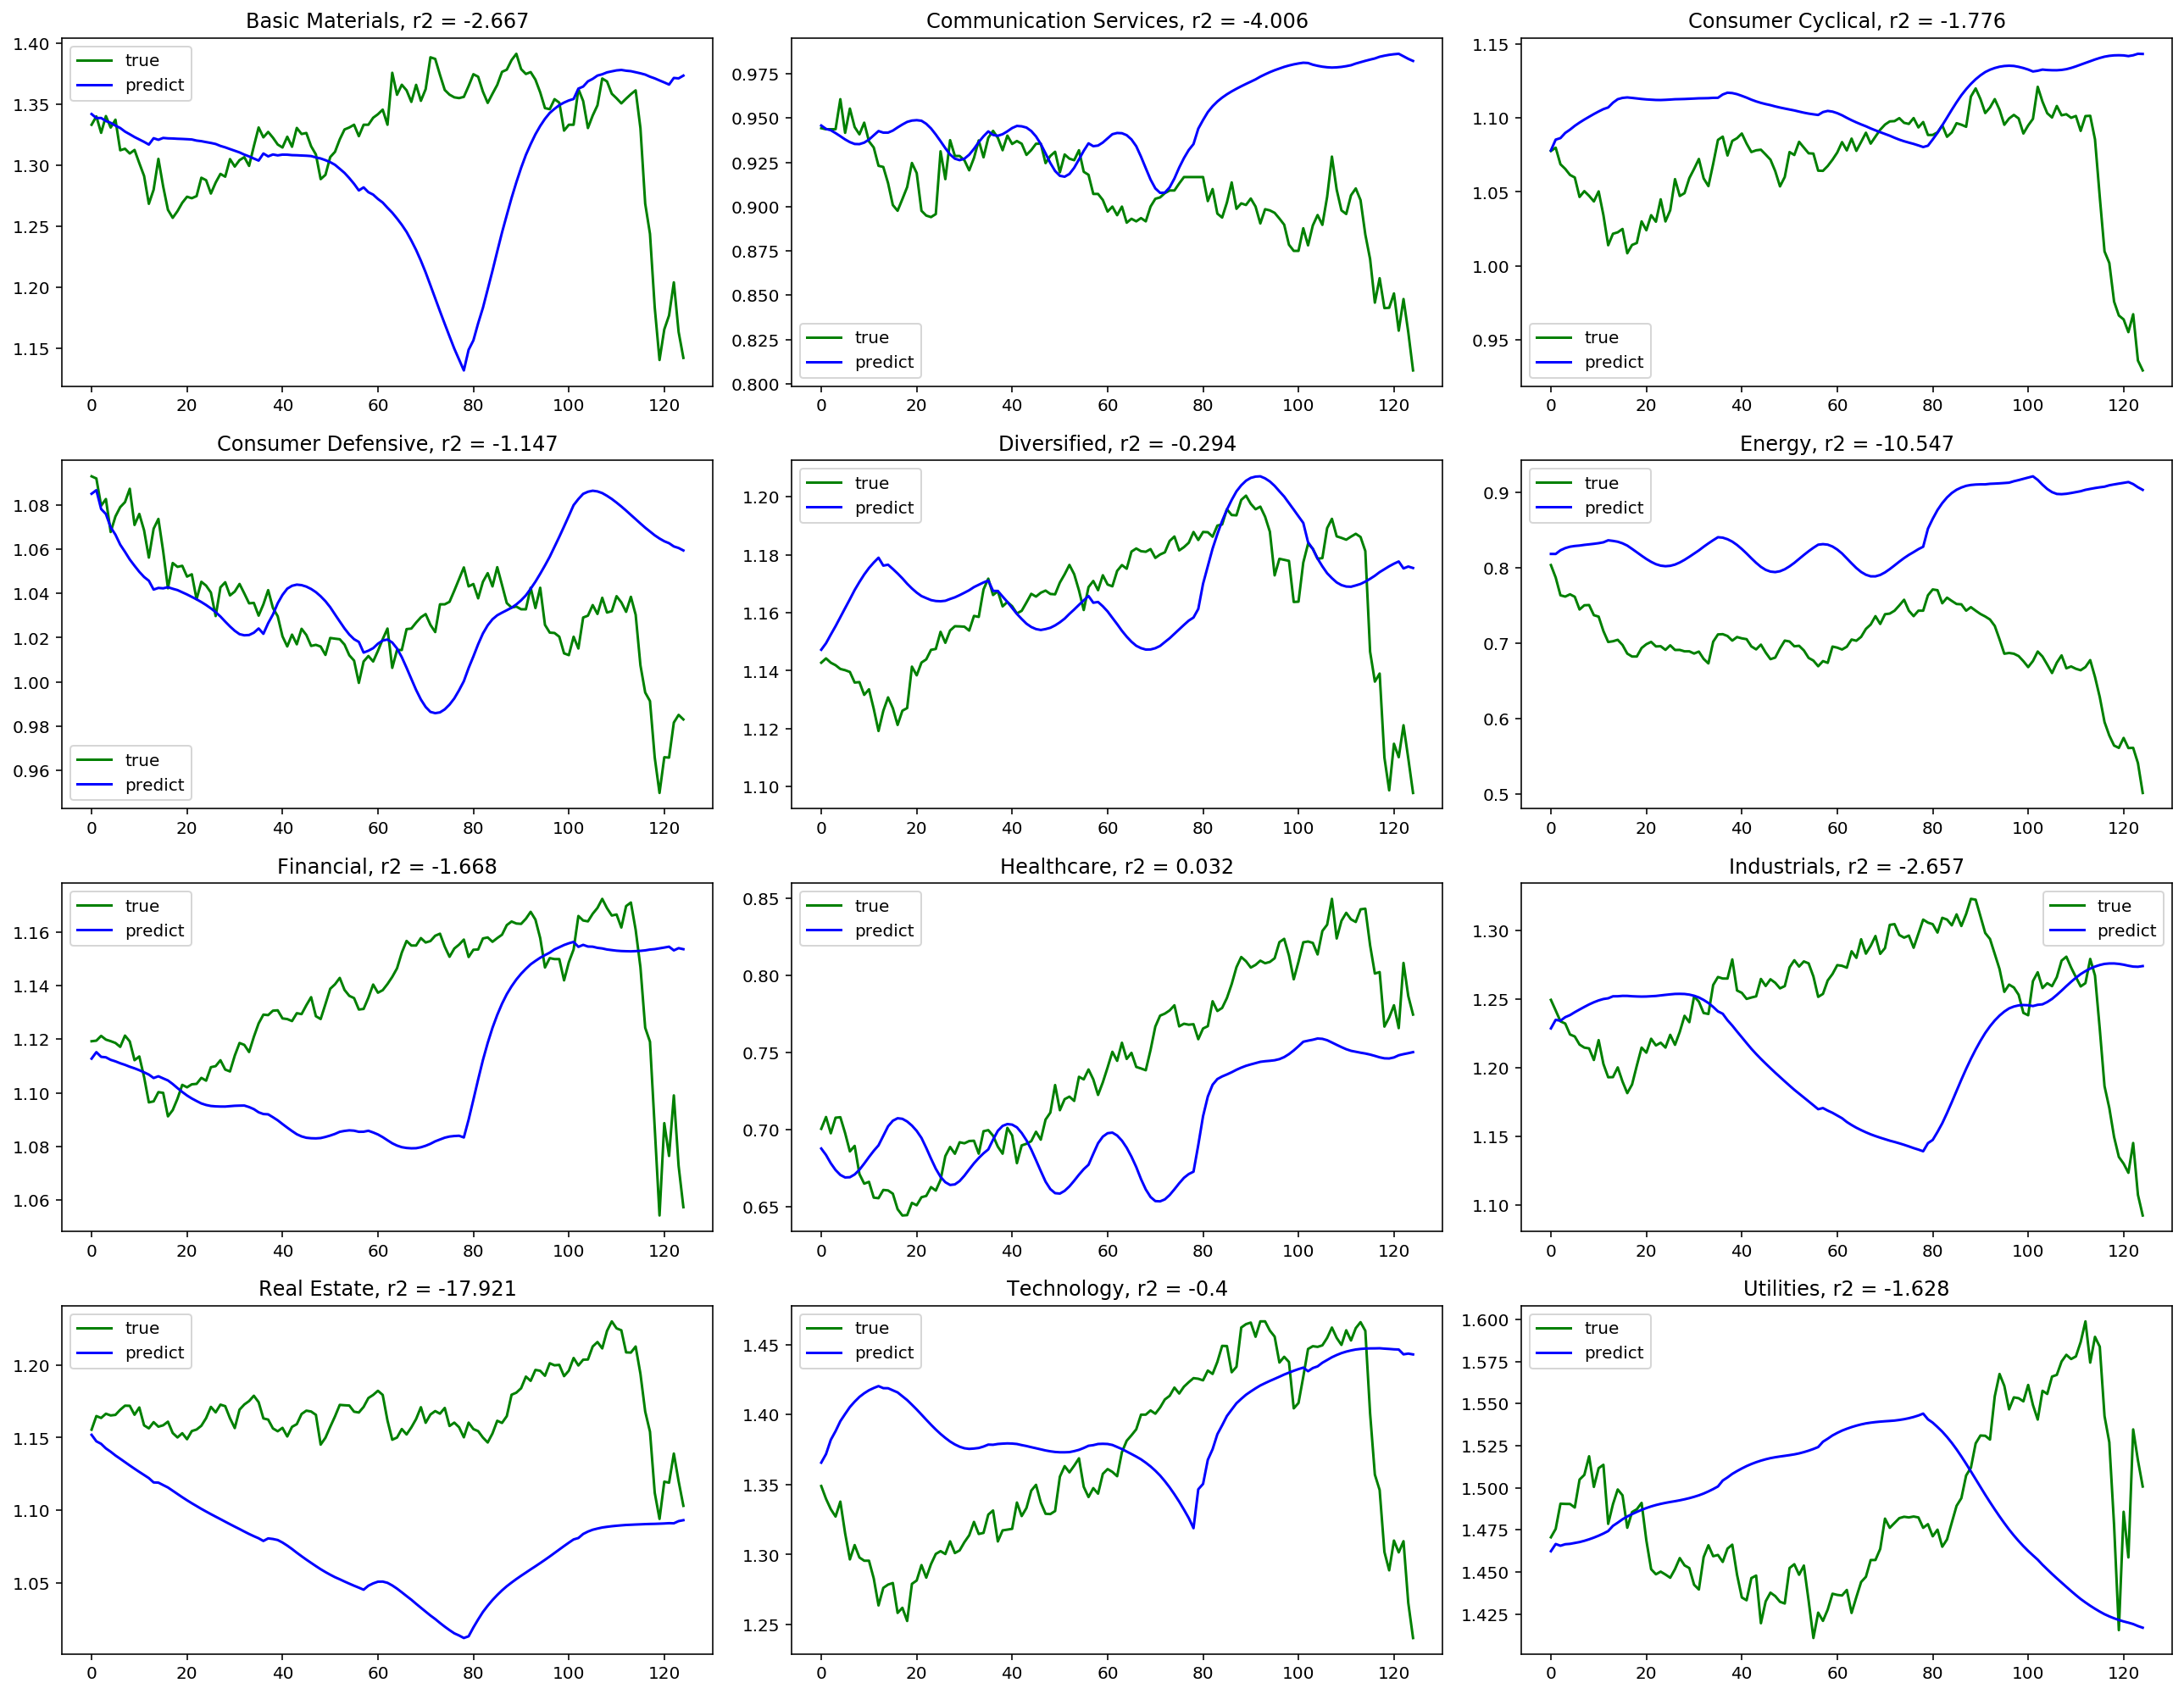

In [224]:
# 6.1. Visualizing full-step (125 days) forecast for sectors on TEST data
# attention: this cell can take several minutes

rows, cols = range(4), range(3)
idx = 0

fig, ax = plt.subplots(4,3, figsize=(18,14))
for r in rows:
    for c in cols:
        target = list(sector_models.keys())[idx]
        model = sector_models[target]
        train, test, scaler, scaler_target = sector_scaled_dict[target]
        test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)
        pred, true = forecast_Nsteps_rnn(N_periods=125, fitted_model=model, scaler_target=scaler_target, 
                                        test_scaled=test, target_name=target, plot_chart=False)
        
        r2 = round(r2_score(true, pred),3)
        ax[r][c].set_title(f'{target}, r2 = {r2}')
        ax[r][c].plot(true, c='g', label='true')
        ax[r][c].plot(pred, c='b', label='predict')
        ax[r][c].legend(loc='best')
        idx += 1

plt.tight_layout()
plt.show()

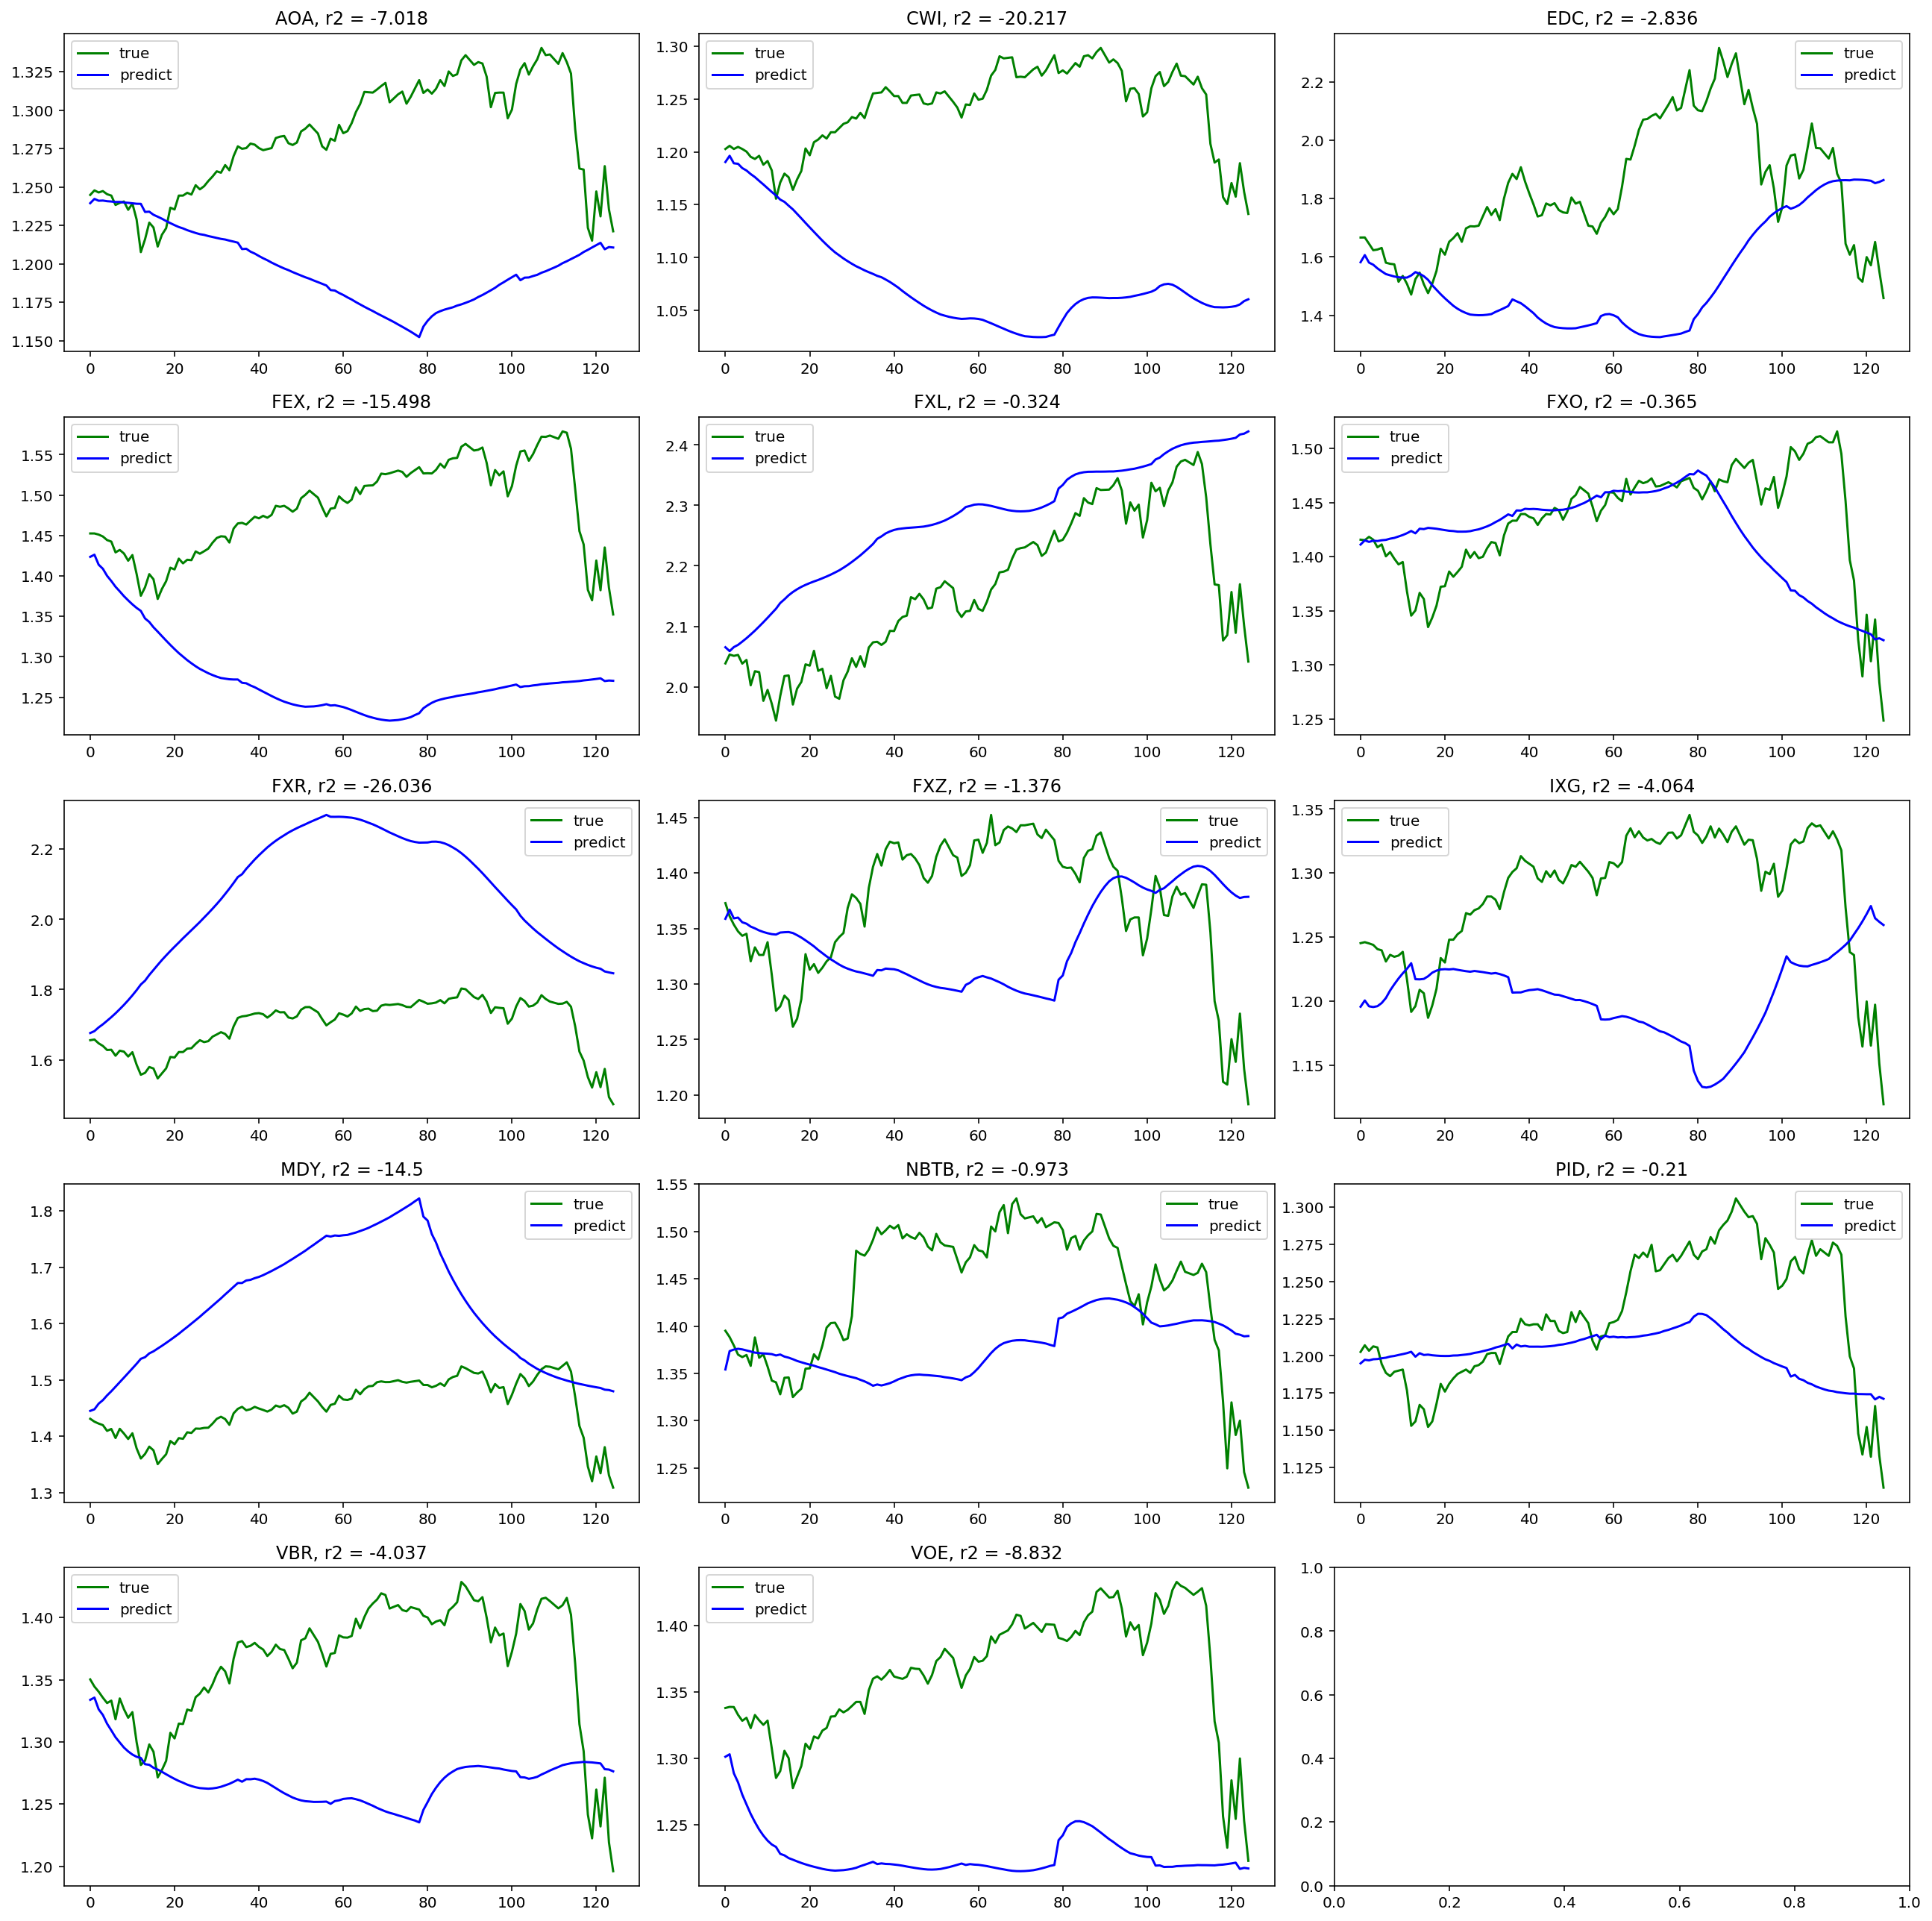

In [225]:
# 6.2. Visualizing full-step (125 days) forecast for cluster centers on TEST data
# attention: this cell can take several minutes

rows, cols = range(5), range(3)
idx = 0

fig, ax = plt.subplots(5,3, figsize=(18,18))
for r in rows:
    for c in cols:
        if idx < 14:
            target = list(cluster_models.keys())[idx]
            model = cluster_models[target]
            train, test, scaler, scaler_target = cluster_scaled_dict[target]
            test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)
            pred, true = forecast_Nsteps_rnn(N_periods=125, fitted_model=model, scaler_target=scaler_target, 
                                            test_scaled=test, target_name=target, plot_chart=False)

            r2 = round(r2_score(true, pred),3)
            ax[r][c].set_title(f'{target}, r2 = {r2}')
            ax[r][c].plot(true, c='g', label='true')
            ax[r][c].plot(pred, c='b', label='predict')
            ax[r][c].legend(loc='best')
            idx += 1

plt.tight_layout()
plt.show()

- As in the case of ARIMA models, forecasting for several periods ahead of such complex and volatile variables as stock prices is difficult to implement and R2 metric does not reach normal values.  
- However, visually it is possible to notice that unlike ARIMA-models which essentially predict a forecast of a linear kind, here the neural network generates some similarity of volotilities, cycles and changing directions, as for example for sector Energy.  
- This gives some hope for the possibility of applicability of such models, if not for a regression task, but for a binary classifier with Growth-Drop (binnary) classes, which will be studied in the section below.

#### Collecting all metrics and Binnary Classifiers

This part will test the predictive ability of trained models to guess the direction of change (Rise or Fall) as a Binary Classifier.

Metrics for binary classifier: accuracy and f1-score

Final results will be collected with r2 scores to DataFrame and saved to `datasets_4_modelling` folder

In [226]:
# 7.1. testing Sector composites. 1-step-forecast and 125-days LT-forecast
# attention: this cell can take 5 minutes

rnn1_models_metrics = pd.DataFrame(columns=['cluster_type', 'cluster_name', 'r2_1d', 'r2_125d', 
                                             'acc_1d', 'f1_1d', 'acc_125d', 'f1_125d'])

cluster_type, cluster_name, r2_1d, r2_125d, acc_1d, f1_1d, acc_125d, f1_125d = [], [], [], [], [], [], [], []

for collection, scaled_dict in zip([sector_models, cluster_models],
                                  [sector_scaled_dict, cluster_scaled_dict]):
    
    for target in collection.keys():
        model = collection[target]
        train, test, scaler, scaler_target = scaled_dict[target]
        test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)

        pred, true = forecast_1step_rnn(fitted_model=model, scaler_target=scaler_target, test_tensor=test_tensor,
                                           test_scaled=test, target_name=target, plot_chart=False)

        pred_lt, true_lt = forecast_Nsteps_rnn(N_periods=125, fitted_model=model, scaler_target=scaler_target, 
                                                test_scaled=test, target_name=target, plot_chart=False)

        pred_bin = create_binnary_vector(pred) 
        true_bin = create_binnary_vector(true)

        pred_lt_bin = create_binnary_vector(pred_lt) 
        true_lt_bin = create_binnary_vector(true_lt)
        
        if collection == sector_models:
            cluster_type.append('sector')
        else:
            cluster_type.append('corr_cluster')
            
        cluster_name.append(target)

        r2_1d.append(r2_score(true, pred))
        acc_1d.append(accuracy_score(true_bin, pred_bin))
        f1_1d.append(f1_score(true_bin, pred_bin))

        r2_125d.append(r2_score(true_lt, pred_lt))
        acc_125d.append(accuracy_score(true_lt_bin, pred_lt_bin))
        f1_125d.append(f1_score(true_lt_bin, pred_lt_bin))
        
rnn1_models_metrics.cluster_type = cluster_type
rnn1_models_metrics.cluster_name = cluster_name
rnn1_models_metrics.r2_1d = r2_1d
rnn1_models_metrics.r2_125d = r2_125d
rnn1_models_metrics.acc_1d = acc_1d
rnn1_models_metrics.acc_125d = acc_125d
rnn1_models_metrics.f1_1d = f1_1d
rnn1_models_metrics.f1_125d = f1_125d

In [227]:
# 7.2. Looking to overall results
print('overall stats')
print(80*'-')
display(rnn1_models_metrics.describe())
print(80*'*')

print('full table')
print(80*'-')
display(rnn1_models_metrics)

overall stats
--------------------------------------------------------------------------------


r2_1d    r2_125d     acc_1d      f1_1d   acc_125d    f1_125d
count  26.000000  26.000000  26.000000  26.000000  26.000000  26.000000
mean    0.336491  -5.806400   0.491148   0.502657   0.479692   0.465049
std     1.548832   7.223628   0.034800   0.058003   0.043729   0.083976
min    -6.872105 -26.036436   0.420635   0.375000   0.384000   0.349515
25%     0.654849  -8.378882   0.476190   0.462717   0.456000   0.413793
50%     0.737708  -2.662097   0.484127   0.513390   0.476000   0.447028
75%     0.811922  -1.016541   0.511905   0.538738   0.510000   0.520804
max     0.899943   0.031711   0.579365   0.624204   0.552000   0.688172

********************************************************************************
full table
--------------------------------------------------------------------------------


cluster_type            cluster_name     r2_1d    r2_125d    acc_1d  \
0         sector         Basic Materials  0.742225  -2.666732  0.468254   
1         sector  Communication Services -1.562772  -4.005827  0.444444   
2         sector       Consumer Cyclical  0.709565  -1.775940  0.484127   
3         sector      Consumer Defensive  0.561721  -1.147175  0.468254   
4         sector             Diversified  0.720487  -0.293514  0.500000   
5         sector                  Energy -6.872105 -10.547311  0.539683   
6         sector               Financial  0.766511  -1.668193  0.579365   
7         sector              Healthcare  0.882955   0.031711  0.420635   
8         sector             Industrials  0.715624  -2.657463  0.484127   
9         sector             Real Estate  0.602688 -17.921268  0.484127   
10        sector              Technology  0.824044  -0.400026  0.484127   
11        sector               Utilities  0.812030  -1.628359  0.484127   
12  corr_cluster                     AOA  0.851898  -7.018110  0.484127   
13  corr_cluster                     CWI  0.793089 -20.216937  0.531746   
14  corr_cluster                     EDC  0.651885  -2.836057  0.531746   
15  corr_cluster                     FEX  0.713760 -15.497578  0.484127   
16  corr_cluster                     FXL  0.897735  -0.323658  0.531746   
17  corr_cluster                     FXO  0.873919  -0.364733  0.428571   
18  corr_cluster                     FXR  0.785687 -26.036436  0.492063   
19  corr_cluster                     FXZ  0.733191  -1.376297  0.515873   
20  corr_cluster                     IXG  0.462131  -4.064455  0.468254   
21  corr_cluster                     MDY  0.795980 -14.500352  0.492063   
22  corr_cluster                    NBTB  0.811599  -0.972996  0.523810   
23  corr_cluster                     PID  0.899943  -0.209592  0.476190   
24  corr_cluster                     VBR  0.663741  -4.036635  0.476190   
25  corr_cluster                     VOE -0.088771  -8.832473  0.492063   

       f1_1d  acc_125d   f1_125d  
0   0.446281     0.464  0.349515  
1   0.375000     0.448  0.439024  
2   0.462810     0.472  0.492308  
3   0.417391     0.520  0.444444  
4   0.511628     0.464  0.488550  
5   0.452830     0.432  0.449612  
6   0.607407     0.480  0.480000  
7   0.482270     0.488  0.555556  
8   0.424779     0.416  0.353982  
9   0.532374     0.472  0.421053  
10  0.518519     0.384  0.429630  
11  0.539007     0.504  0.569444  
12  0.557823     0.456  0.413793  
13  0.542636     0.520  0.400000  
14  0.542636     0.504  0.530303  
15  0.563758     0.456  0.451613  
16  0.624204     0.536  0.688172  
17  0.462687     0.456  0.413793  
18  0.492063     0.552  0.555556  
19  0.478632     0.488  0.360000  
20  0.537931     0.424  0.419355  
21  0.536232     0.552  0.600000  
22  0.464286     0.544  0.477064  
23  0.521739     0.512  0.548148  
24  0.459016     0.496  0.400000  
25  0.515152     0.432  0.360360

In average clusters centers metric are higher than for sector composites.  
Here I've taken median as a measure for averaging, since mean values biased by low outliers.    
Models shows moderate and poor results for binary classifier problem with accurace range from 0.42 to 0.58. On the other hand, f1 and accuracy are not shifted down for long-term forecasts.

Of course, it cannot be said that such accuracy indicators are sufficient for commercial purposes, but the results show that rnn can be used for purposes of determining recommendations when buying or selling securities, provided the models are improved.

In [20]:
# 7.3. Exporting result table and data to pickle
# -- df already saved

#with open('datasets_4_modelling/rnn_basic_results.pkl', 'wb') as f: 
#    pickle.dump(rnn1_models_metrics, f)

#### Testing models on randomly selected companies from clusters

This part of the work deals with the following question:  
- whether and with what quality it is possible to use the models trained at the centers of clusters to generate forecasts for companies from these clusters?

The quality of metrics in particular will be a certain metric of the degree of homogeneity of the cluster companies.

This check will be carried out for the following clusters (showing average and good metrics):
- sector composites: Basic Materials, Utilities, Financial
- cluster centers: FXL, AOA, FXO

At the same time, the selected centers are heterogeneous in terms of cluster power and vary in a wide range, so for each cluster in a random order will be selected 25 companies (without repeating), for which will be built 1-step-ahead-forecasts and calculated r2-scores. The final results will be displayed as statistics.

On the statistics of the previous example, we saw that extreme values (negative) for r2 shifted the arithmetic mean. Therefore, such values here will be equated to 0.

In [269]:
# 8.1. Prepare data for analysis
# attention: depending of N (sample power per cluster) - it could take a few minutes

# 8.1.1. Normalizing all prices
cleaned_prices = pd.read_csv('datasets/df_prices_cleaned.csv', encoding='utf-8')
cleaned_prices = cleaned_prices[1:]

try:
    cleaned_prices = cleaned_prices.set_index(pd.to_datetime(cleaned_prices.date, format='%Y-%m-%d'))
    cleaned_prices = cleaned_prices.drop(columns=['date'], axis=1)
except Exception:
    print('already done')

first_price_row = cleaned_prices.iloc[0]
df_prices_norm = cleaned_prices.copy()

for col, first_price in zip(cleaned_prices.columns, first_price_row):
    norm_prices = cleaned_prices[col]/first_price
    df_prices_norm[col] = norm_prices

    
# 8.1.2. Loading models for selected tickers


# 8.1.3. Creating random company samples for each cluster
N = 25  
np.random.seed(42) # delete - if need to another resample

sector_comps_1 = np.random.choice(sector_comps['Basic Materials'].index, size=N, replace=False)
sector_comps_2 = np.random.choice(sector_comps['Utilities'].index, size=N, replace=False)
sector_comps_3 = np.random.choice(sector_comps['Financial'].index, size=N, replace=False)

cluster_comps_1 = np.random.choice(cluster_comps['FXL'].T.index, size=N, replace=False)
cluster_comps_2 = np.random.choice(cluster_comps['AOA'].T.index, size=N, replace=False)
cluster_comps_3 = np.random.choice(cluster_comps['FXO'].T.index, size=N, replace=False)
# -- important notice: DO NOT CHANGE to `replace=True` in sampling, it will rise errors


# 8.1.4. Slicing time series for chosen companies samples

sector_comps_1 = df_prices_norm[sector_comps_1]
sector_comps_2 = df_prices_norm[sector_comps_2]
sector_comps_3 = df_prices_norm[sector_comps_3]

cluster_comps_1 = df_prices_norm[cluster_comps_1] 
cluster_comps_2 = df_prices_norm[cluster_comps_2]
cluster_comps_3 = df_prices_norm[cluster_comps_3]

# 8.1.5. Scale and collect data in dicts. Each dict for separate cluster center
sector_scaled_1, sector_scaled_2, sector_scaled_3 = dict(), dict(), dict()
cluster_scaled_1, cluster_scaled_2, cluster_scaled_3 = dict(), dict(), dict()
sector_scaled_all, cluster_scaled_all = dict(), dict()

for c, name, d in zip([sector_scaled_1, sector_scaled_2, sector_scaled_3],
                      ['Basic Materials', 'Utilities', 'Financial'],
                      [sector_comps_1, sector_comps_2, sector_comps_3]):
    for comp in d.columns:
        df = pd.DataFrame(d[comp])
        df = df.set_index(pd.to_datetime(df.index))
        df = add_period_cols(df)
        try:
            df = df.drop(columns=['day_of_week'], axis=1)
        except Exception:
            pass
        
        df_train, df_test = split_to_train_test(df, test_portion=0.2)
        df_train_scaled, df_test_scaled, df_scaler, df_scaler_target = scale_data(MinMaxScaler(), df_train, df_test, 
                                                                              target_name=comp, show_stats=False)
    
        c[comp] = (df_train_scaled, df_test_scaled, df_scaler, df_scaler_target)

    sector_scaled_all[name] = c


for c, name, d in zip([cluster_scaled_1, cluster_scaled_2, cluster_scaled_3],
                      ['FXL', 'AOA', 'FXO'],
                      [cluster_comps_1, cluster_comps_2, cluster_comps_3]):
    
    for comp in d.columns:
        df = pd.DataFrame(d[comp])
        df = df.set_index(pd.to_datetime(df.index))
        df = add_period_cols(df)
        
        try:
            df = df.drop(columns=['day_of_week'], axis=1)
        except Exception:
            pass
        df_train, df_test = split_to_train_test(df, test_portion=0.2)
        df_train_scaled, df_test_scaled, df_scaler, df_scaler_target = scale_data(MinMaxScaler(), df_train, df_test, 
                                                                              target_name=comp, show_stats=False)
    
        c[comp] = (df_train_scaled, df_test_scaled, df_scaler, df_scaler_target)

    cluster_scaled_all[name] = c

In [270]:
# 8.2. Calculate 1-step forecasts and r2 score

sector_scores_dict = dict.fromkeys(['Basic Materials', 'Utilities', 'Financial']) 
cluster_scores_dict = dict.fromkeys(['FXL', 'AOA', 'FXO'])


for key in sector_scores_dict.keys():
    r2_s = []
    model = sector_models[key]
    data = sector_scaled_all[key]
    for comp in data.keys():
        target = comp
        train, test, scaler, scaler_target = sector_scaled_all[key][comp]
        test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)
        pred, true = forecast_1step_rnn(fitted_model=model, scaler_target=scaler_target, test_tensor=test_tensor,
                                       test_scaled=test, target_name=target, plot_chart=False)
        
        r2 = max(r2_score(true, pred), 0)
        r2_s.append(r2)
    r2_s = pd.Series(r2_s)
    print(f'r2 stats for {key}:')
    print(f'mean={r2_s.mean():.2f}, median={r2_s.median():.2f}, full range={r2_s.min():.2f}:{r2_s.max():.2f}')
    print(70*'-')
    sector_scores_dict[key] = r2_s
    
for key in cluster_scores_dict.keys():
    r2_s = []
    model = cluster_models[key]
    data = cluster_scaled_all[key]
    for comp in data.keys():
        target = comp
        train, test, scaler, scaler_target = cluster_scaled_all[key][comp]
        test_tensor, test_target = create_tensor(test, test[target], window_size=90, show_shape=False)
        pred, true = forecast_1step_rnn(fitted_model=model, scaler_target=scaler_target, test_tensor=test_tensor,
                                       test_scaled=test, target_name=target, plot_chart=False)
        
        r2 = max(r2_score(true, pred), 0)
        r2_s.append(r2)
    r2_s = pd.Series(r2_s)
    print(f'r2 stats for {key}:')
    print(f'mean={r2_s.mean():.2f}, median={r2_s.median():.2f}, full range={r2_s.min():.2f}:{r2_s.max():.2f}')
    print(70*'-')
    cluster_scores_dict[key] = r2_s

r2 stats for Basic Materials:
mean=0.23, median=0.00, full range=0.00:0.92
----------------------------------------------------------------------
r2 stats for Utilities:
mean=0.72, median=0.79, full range=0.00:0.94
----------------------------------------------------------------------
r2 stats for Financial:
mean=0.33, median=0.16, full range=0.00:0.91
----------------------------------------------------------------------
r2 stats for FXL:
mean=0.82, median=0.85, full range=0.45:0.97
----------------------------------------------------------------------
r2 stats for AOA:
mean=0.68, median=0.80, full range=0.00:0.92
----------------------------------------------------------------------
r2 stats for FXO:
mean=0.82, median=0.85, full range=0.38:0.93
----------------------------------------------------------------------


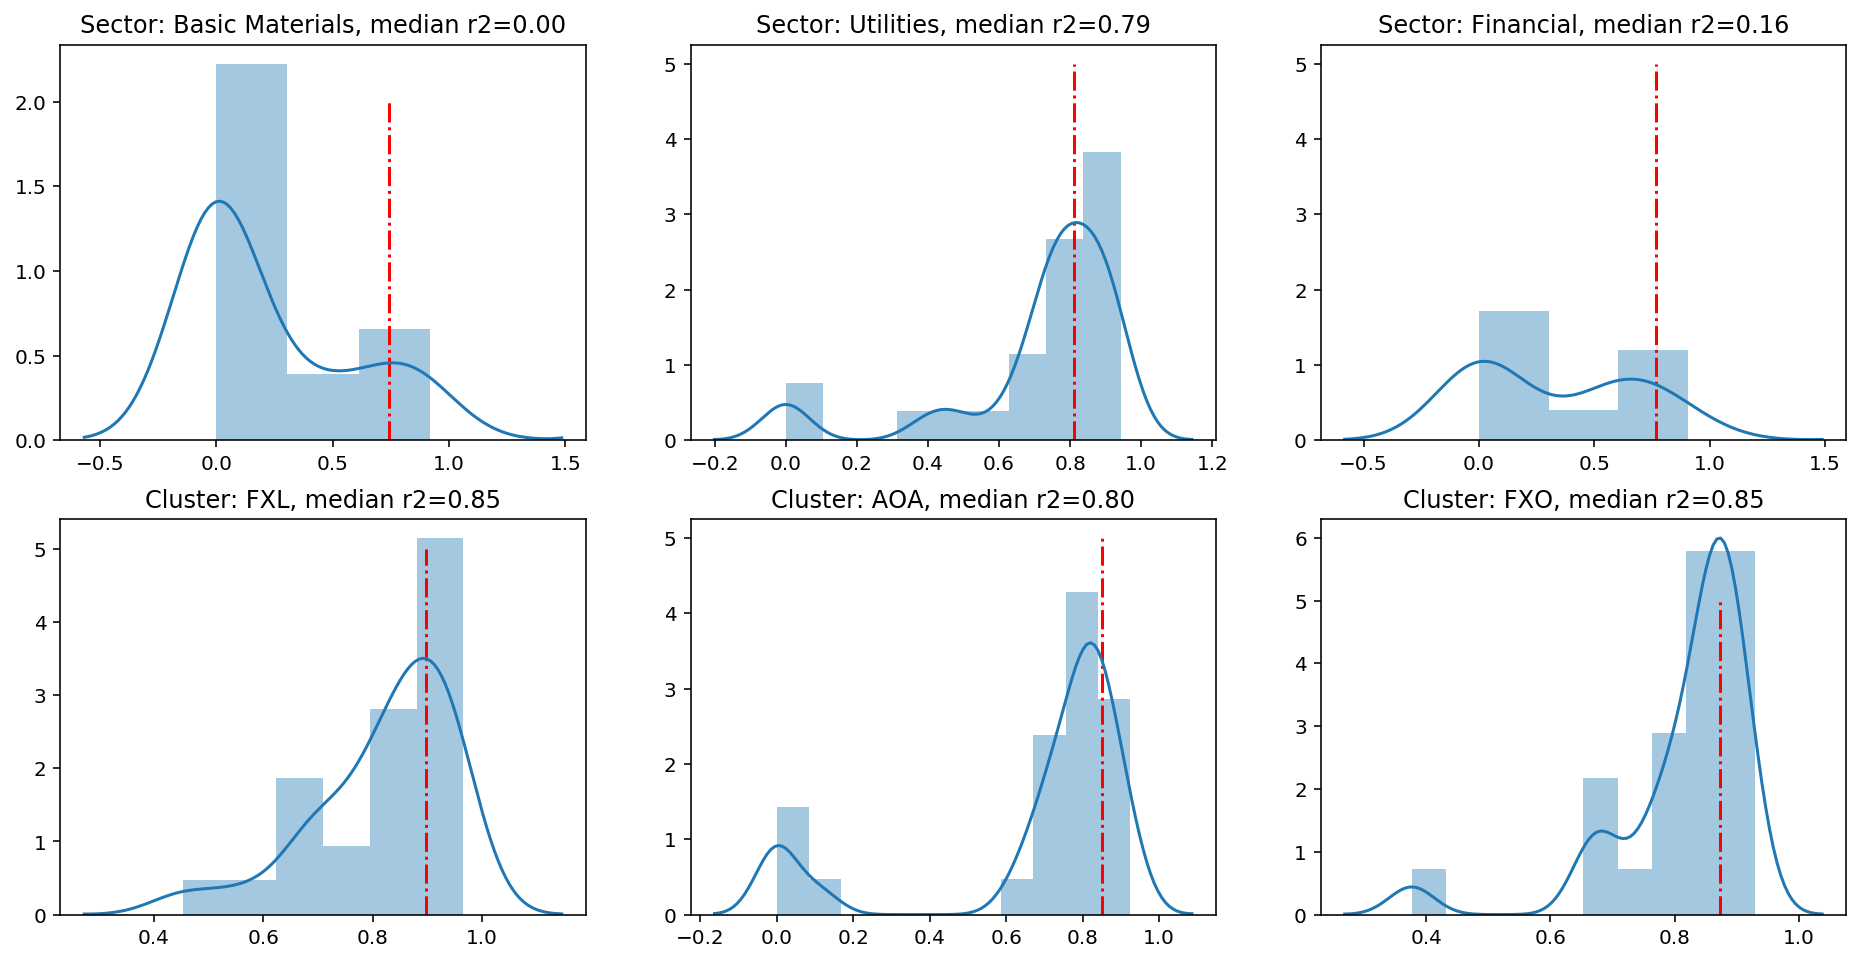

In [271]:
# 8.3. Visual comparison

fig, ax = plt.subplots(2,3, figsize=(16,8))
ax[0][0].set_title(f'Sector: Basic Materials, median r2={sector_scores_dict["Basic Materials"].median():.2f}')
ax[0][1].set_title(f'Sector: Utilities, median r2={sector_scores_dict["Utilities"].median():.2f}')
ax[0][2].set_title(f'Sector: Financial, median r2={sector_scores_dict["Financial"].median():.2f}')
ax[1][0].set_title(f'Cluster: FXL, median r2={cluster_scores_dict["FXL"].median():.2f}')
ax[1][1].set_title(f'Cluster: AOA, median r2={cluster_scores_dict["AOA"].median():.2f}')
ax[1][2].set_title(f'Cluster: FXO, median r2={cluster_scores_dict["FXO"].median():.2f}')

sns.distplot(sector_scores_dict['Basic Materials'], norm_hist=True, ax=ax[0][0])
sns.distplot(sector_scores_dict['Utilities'], norm_hist=True, ax=ax[0][1])
sns.distplot(sector_scores_dict['Financial'], norm_hist=True, ax=ax[0][2])

sns.distplot(cluster_scores_dict['FXL'], norm_hist=True, ax=ax[1][0])
sns.distplot(cluster_scores_dict['AOA'], norm_hist=True, ax=ax[1][1])
sns.distplot(cluster_scores_dict['FXO'], norm_hist=True, ax=ax[1][2])

ax[0][0].vlines(rnn1_models_metrics.r2_1d.loc[rnn1_models_metrics.cluster_name=='Basic Materials'].values[0], 
                0, 2, color='r', linestyle='-.')                   

ax[0][1].vlines(rnn1_models_metrics.r2_1d.loc[rnn1_models_metrics.cluster_name=='Utilities'].values[0], 
                0, 5, color='r', linestyle='-.')

ax[0][2].vlines(rnn1_models_metrics.r2_1d.loc[rnn1_models_metrics.cluster_name=='Financial'].values[0], 
                0, 5, color='r', linestyle='-.')

ax[1][0].vlines(rnn1_models_metrics.r2_1d.loc[rnn1_models_metrics.cluster_name=='FXL'].values[0], 
                0, 5, color='r', linestyle='-.')

ax[1][1].vlines(rnn1_models_metrics.r2_1d.loc[rnn1_models_metrics.cluster_name=='AOA'].values[0], 
                0, 5, color='r', linestyle='-.')

ax[1][2].vlines(rnn1_models_metrics.r2_1d.loc[rnn1_models_metrics.cluster_name=='FXO'].values[0], 
                0, 5, color='r', linestyle='-.')
                   
plt.show()

As can be seen above, in some cases, the models trained on composite indexes can provide acceptable quality of metrics even for companies in the cluster of this composite. Of course, the results above are only a small simulation with random selection of companies, so this conclusion is evidence of the quality of the model itself, but only reflects some coherence of companies in the 1 cluster.


We can notice that the average value of r2 for companies in correlation clusters is closer to the r2 centers of clusters than for clusters formed by sectors. This conclusion is not unambiguous, because I chose 6 centers relatively randomly, but in general, we can say that the idea of merging companies into clusters based on correlation dependence can be used and bring some benefit.